# Introduction

FiveThirtyEight conducted a survey about the sleeping behaviour of people, where mainly [it was pointed out](https://fivethirtyeight.com/features/dear-mona-how-many-couples-sleep-in-separate-beds/) if and why couples would sleep in separated beds. With the help of their [dataset](https://github.com/fivethirtyeight/data/tree/master/sleeping-alone-data) this analysis in turn investigates, if a tendency can be extracted whether someone preferes staying apart from his or her partner, by the individual's circumstances.

## Fetch the data and peek into it

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.metrics import accuracy_score


raw_data_url = "https://raw.githubusercontent.com/fivethirtyeight/data/master/sleeping-alone-data/sleeping-alone-data.csv"
main_dataframe = pd.read_csv(raw_data_url, sep=",", encoding="latin")

let's get a feeling what we can expect and peek into the data

In [2]:
main_dataframe.describe()

,StartDate,EndDate,Which of the following best describes your current relationship status?,"How long have you been in your current relationship? If you are not currently in a relationship, please answer according to your last relationship.","When both you and your partner are at home, how often do you sleep in separate beds?","When you're not sleeping in the same bed as your partner, where do you typically sleep?",Unnamed: 6,"When you're not sleeping in the same bed, where does your partner typically sleep?",Unnamed: 8,What are the reasons that you sleep in separate beds? Please select all that apply.,...,"To what extent do you agree with the following statement: ""sleeping in separate beds helps us to stay together.""","To what extent do you agree with the following statement: ""we sleep better when we sleep in separate beds.""","To what extent do you agree with the following statement:ë_""our sex life has improved as a result of sleeping in separate beds.""ë_",Which of the following best describes your current occupation?,Unnamed: 25,Gender,Age,Household Income,Education,Location (Census Region)
count,1093,1093,1094,1080,1080,483,28,483,22,221,...,482,482,482,1065,289,1006,1006,811,1002,1002
unique,262,259,7,7,7,7,27,7,22,1,...,6,6,6,24,149,3,5,6,6,10
top,7/9/14 18:35,7/9/14 19:43,Married,More than 20 years,Never,Separate bedroom,kids room,"My partner sleeps in our shared bed, I'm the o...",Other (please specify),One of us snores,...,Neither agree nor disagree,Strongly agree,Neither agree nor disagree,Other (please specify),retired,Male,45-60,"$50,000 - $99,999",Bachelor degree,East North Central
freq,15,13,884,468,586,185,2,180,1,221,...,214,116,207,289,72,517,312,314,320,197


covered by following data types 

In [3]:
print(main_dataframe.dtypes.value_counts())

object    31
dtype: int64


## Approach of dataset analysis

The goal is to try to find rules that may estimate a tendency in sleeping behaviour. More precisely, this will be measured by the question


In [5]:
eval_topic = 'To what extent do you agree with the following statement: "sleeping in separate beds helps us to stay together."'

and connected to other features in the dataset. To make findings interpretable the following bar plot will be used

In [6]:
def bar_plot(list_of_labels, list_of_counts, list_of_titles):
    """
        Creates a bar plot to highlight possible feature importance
        
        Note:
            This function expects the 3 input parameter to be ordered by logical relation.
        
        Parameters:
                    list_of_labels (list(list(str)): a set of answer options per evaluation focus
                    list_of_counts (list(list(int)): a set of answer frequencies per evaluation focus
                    list_of_titles (list(str)): a graph title per evaluation focus
    """
    assert len(list_of_labels) == len(list_of_counts) == len(list_of_titles), "can't interprete unmatching list lenghts."
    
    for idx, case in enumerate(zip(list_of_labels, list_of_counts, list_of_titles)):
        labels, counts, title = case
        package = sorted(zip(labels,counts), key=lambda data: data[0])  # sort results to avoid comparison confusion
        labels, counts = zip(*package)
        
        # place two plots per row
        plot_id = idx % 2
        is_new_line = plot_id == 0
        if is_new_line:
            fig, ax = plt.subplots(1,2, figsize=(7, 7), layout="tight")
            if idx + 1 == len(list_of_labels) and idx % 2 == 0:  # last row: don't create more subplots than necessary
                ax[1].axis('off')
        ax[plot_id].set_title(title)
        ax[plot_id].bar(labels, counts)
        ax[plot_id].tick_params('x', labelrotation=90)
        if not is_new_line:
            plt.show()
    plt.show()


In order to keep the focus on the actual analytics, a helper function `group_analysis()` will be introduced, that composes a set of data exploration in a focused group. A standardized way of processing helps to compare the results

In [7]:
def group_analysis(sub_group, 
                   eval_feature, 
                   dataframe):
    """
        Creates a common comparision environment for different topics. At first a feature diversity plot is given out
        subsequentially the answer options are being highlighed
        
        Parameters:
            sub_group (str): the focus group to be evaluated
            eval_feature (str): the main query that is being used to evalute the feature importance against
            dataframe (pandas.DataFrame): the analysis basis
    """

    print("\nStatistics: how all participants voted for this question in general")
    sub_group_dataframe = dataframe.get(sub_group)[dataframe[sub_group].values != "Response"]
    index, counts = sub_group_dataframe.value_counts().index, sub_group_dataframe.value_counts().values
    bar_plot([index], [counts], [sub_group])
    
    print(f"\nTopic: '{eval_topic}'\n")
    list_of_labels = list()
    list_of_counts = list()
    list_of_subgroup_titles = list()
    
    # A sub_group would be 'occupation' where a sub_group_item would be e.g. 'Architecture and Engineering'
    for sub_group_item in list(set(dataframe[sub_group])):

        if sub_group_item == "Response":  # skip non-data content
            continue
        query = dataframe.loc[dataframe[sub_group] == sub_group_item].get(eval_feature)
        if query.dropna().empty:  # skip ignore non-content data
            continue

        labels, counts = query.value_counts().index, query.value_counts().values
        if len(counts) == 0:  # skip ignore non-content data
            continue
        list_of_labels.append(labels)
        list_of_counts.append(counts)
        list_of_subgroup_titles.append(sub_group_item)

    # ..data prepared. Eventually plot composition.
    bar_plot(list_of_labels, list_of_counts, list_of_subgroup_titles)

## Base feature analysis 

Here low-level features are being investiagted, whether they already point out a certain signature. 

In general, the diversity plot throughout the features oftentimes might point out, that the survey may be biased since particular answer options stand out by high votes, sometimes by far. So the results must be consumed consciously.

### Influence of relationship status


Statistics: how all participants voted for this question in general


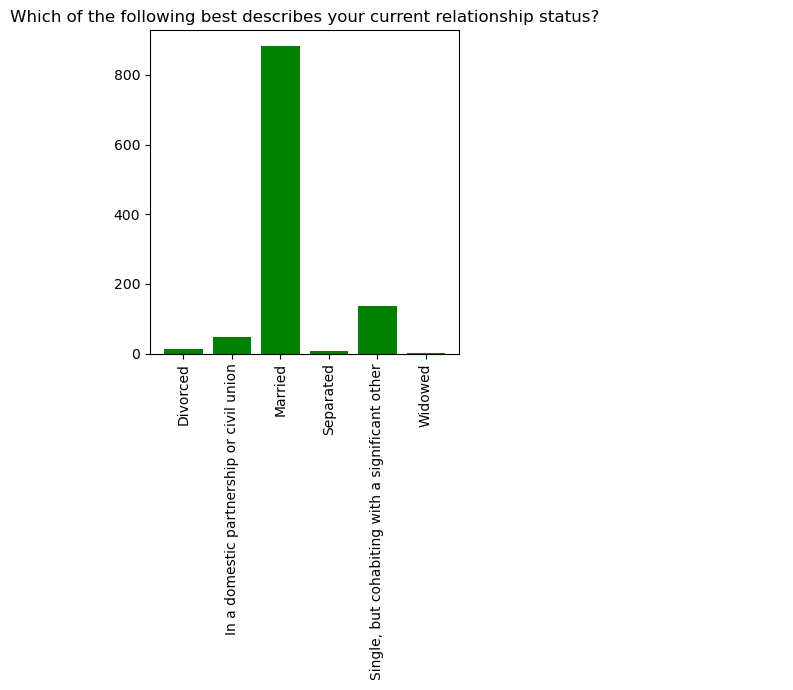


Topic: 'To what extent do you agree with the following statement: "sleeping in separate beds helps us to stay together."'



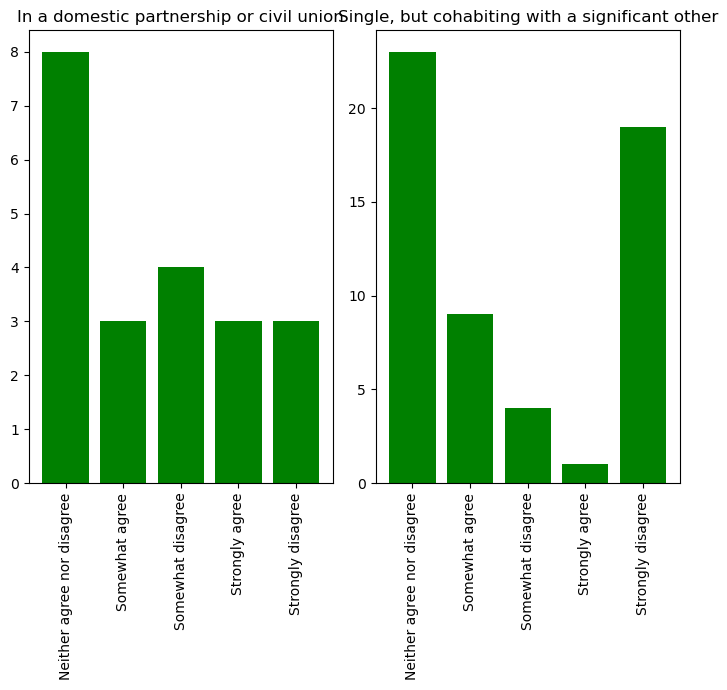

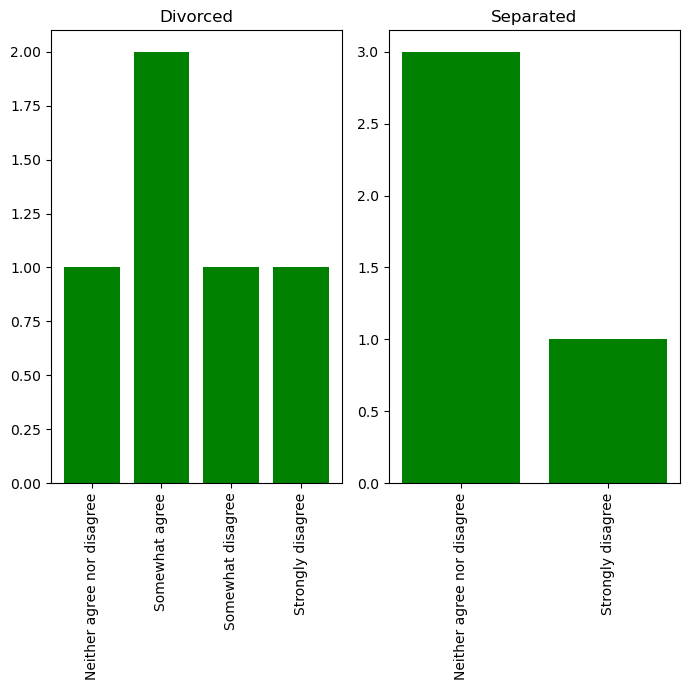

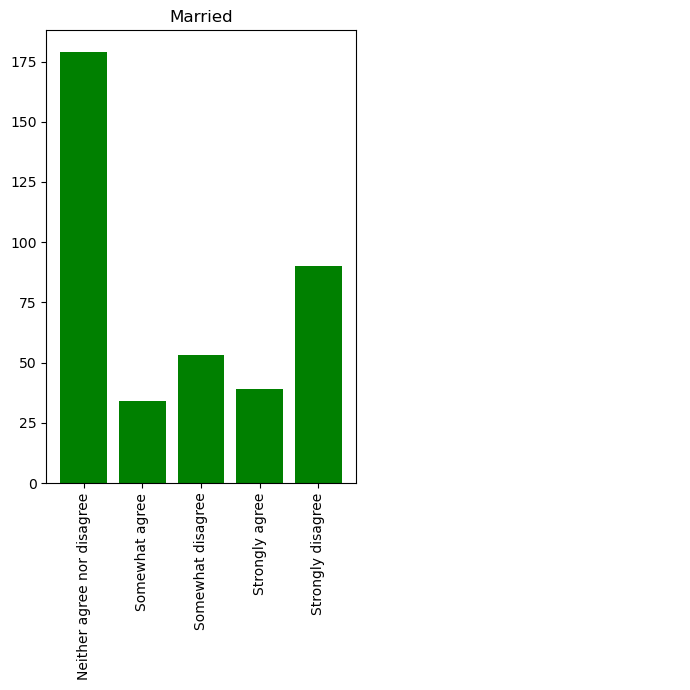

In [8]:
group_analysis('Which of the following best describes your current relationship status?',eval_topic, main_dataframe)

The relationship status, as one main driver why people want to be together, don't show a clear rule alone. However there are married couples that rather disagree, as well as singles cohabiting with the significant other.

### Influence of the individual's occupation 


Statistics: how all participants voted for this question in general


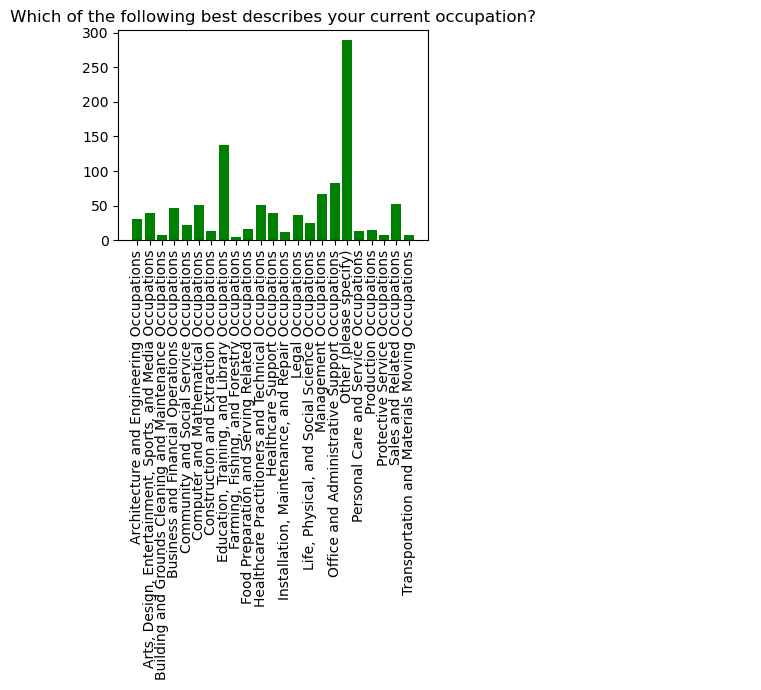


Topic: 'To what extent do you agree with the following statement: "sleeping in separate beds helps us to stay together."'



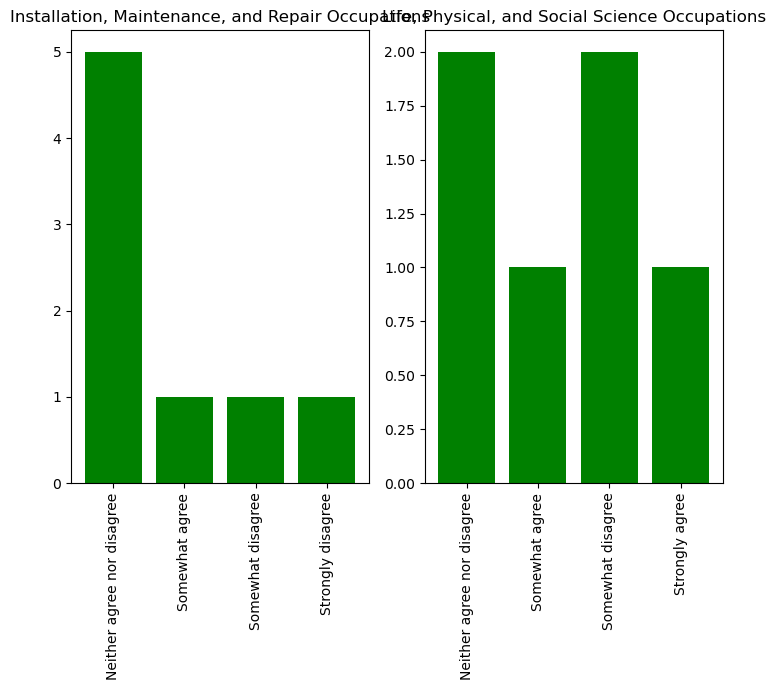

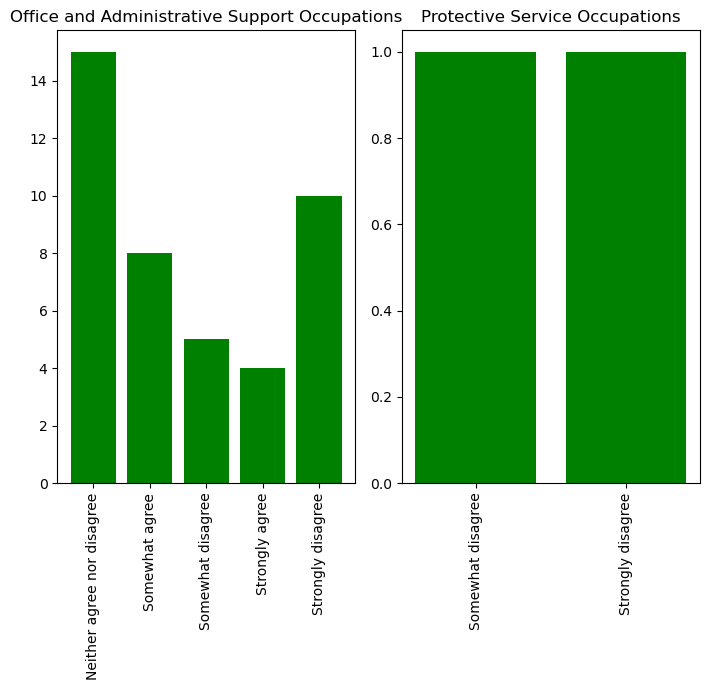

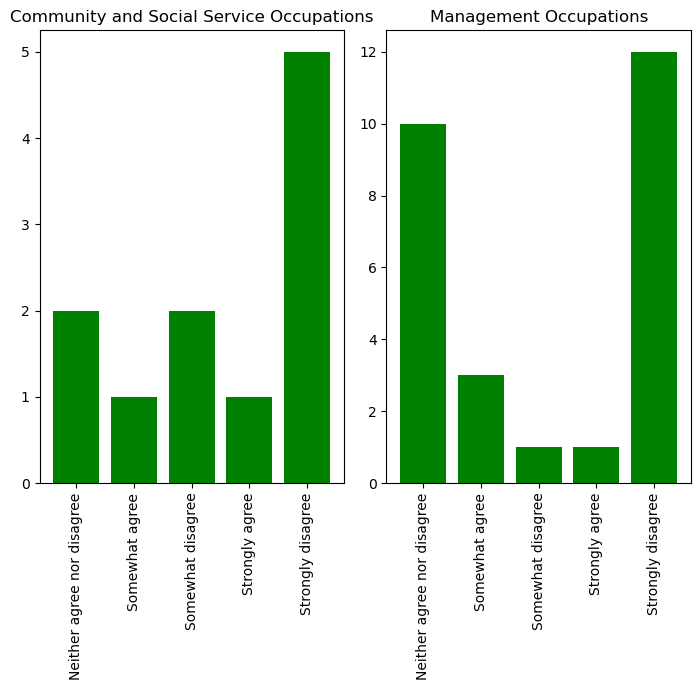

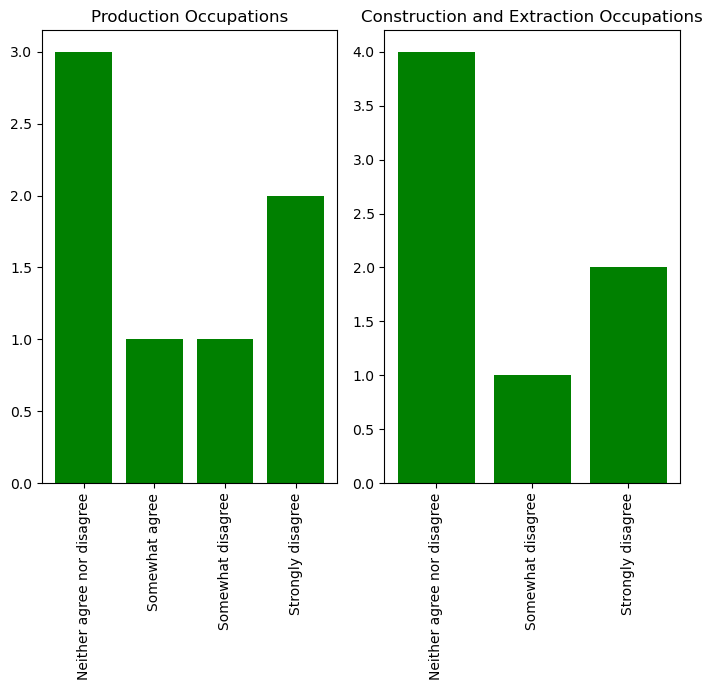

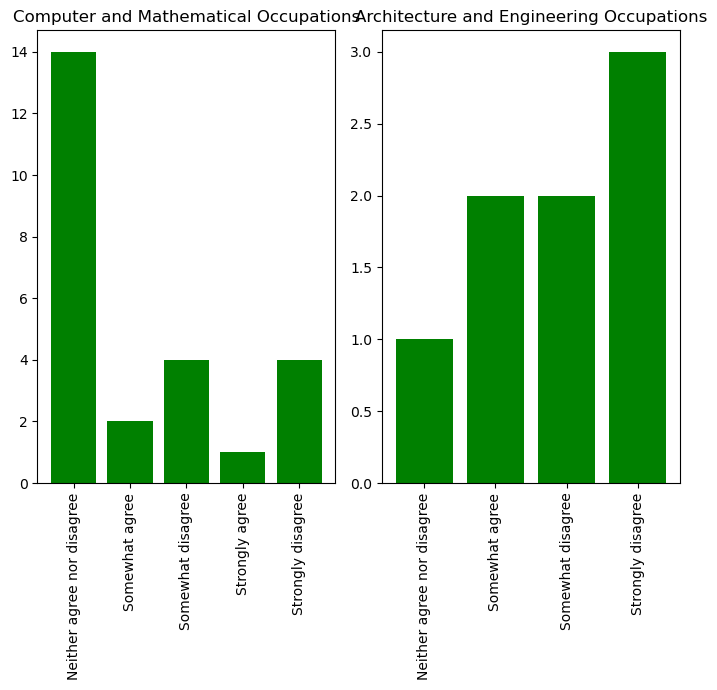

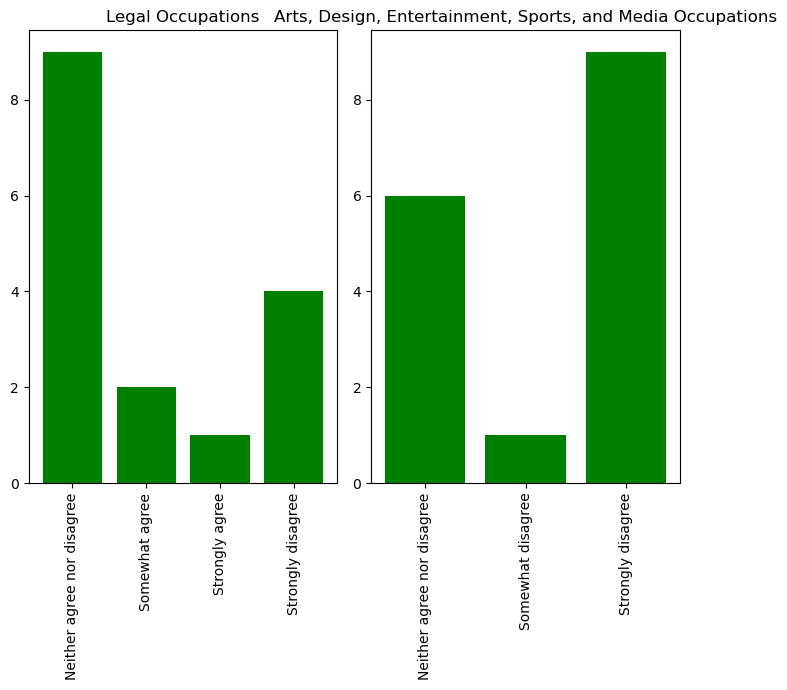

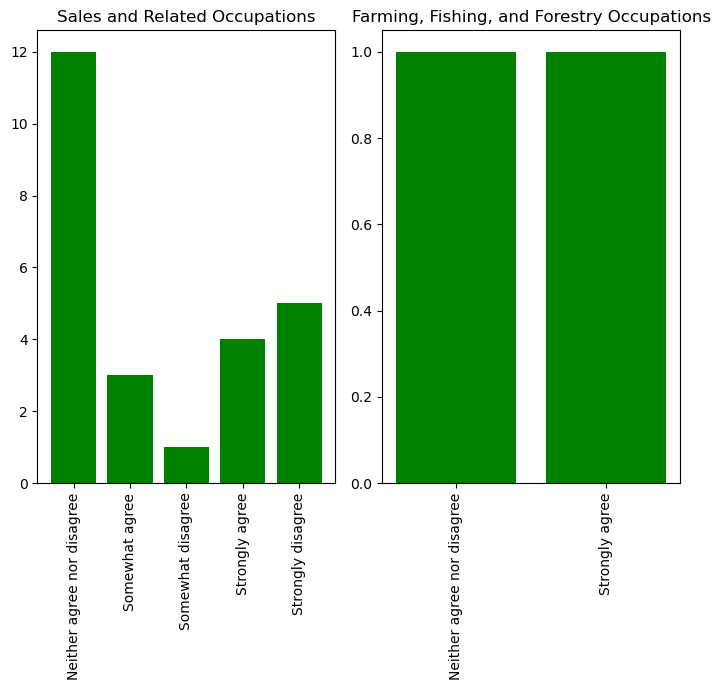

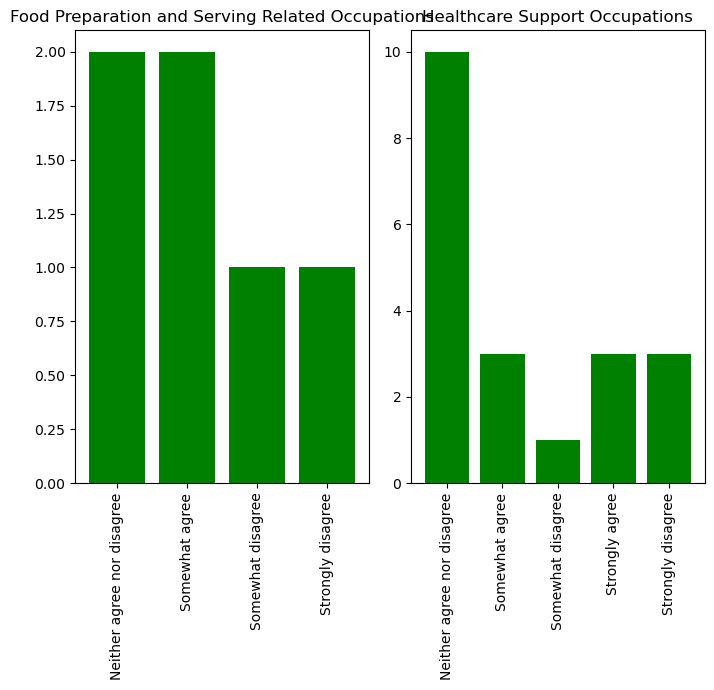

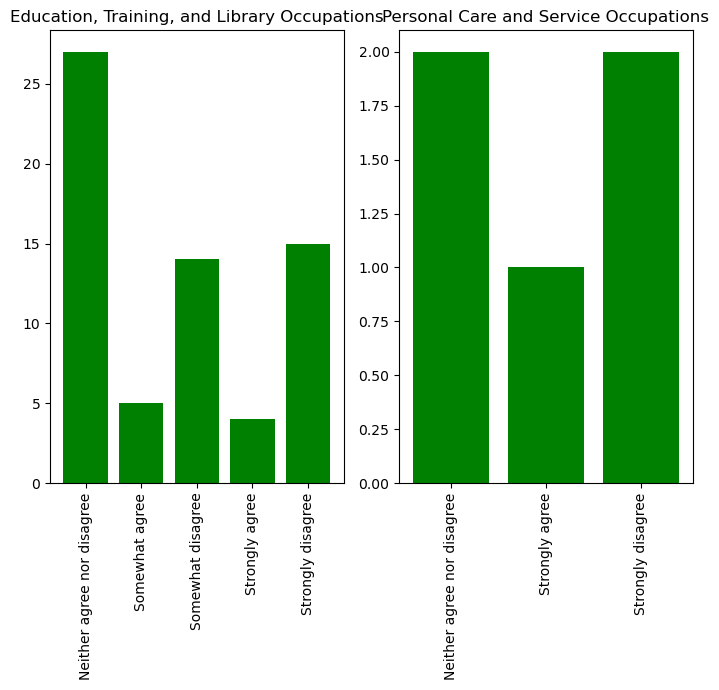

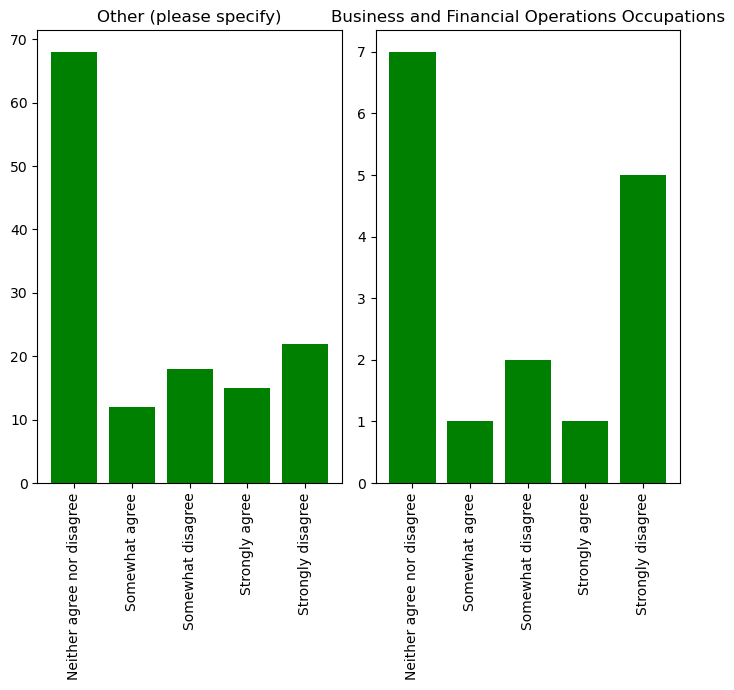

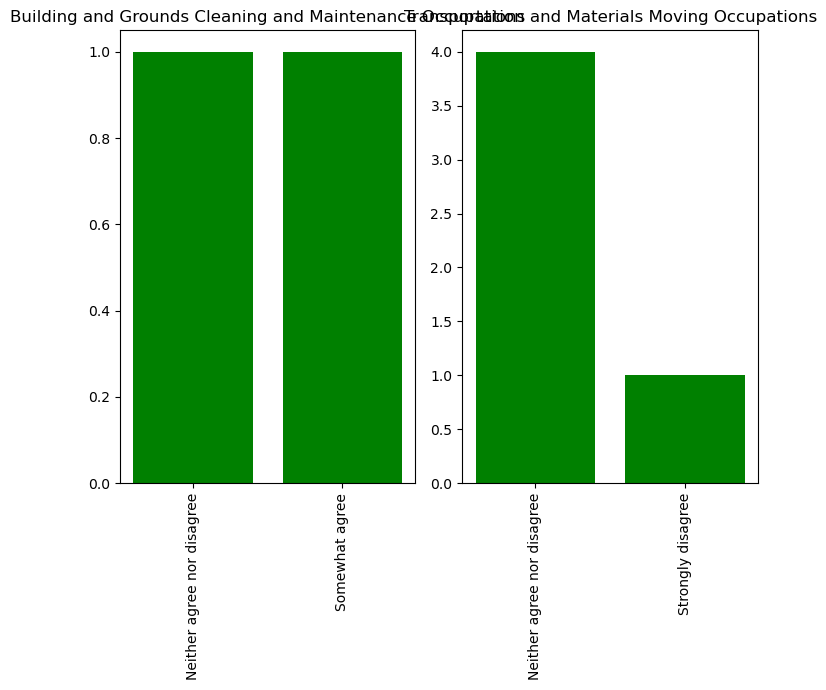

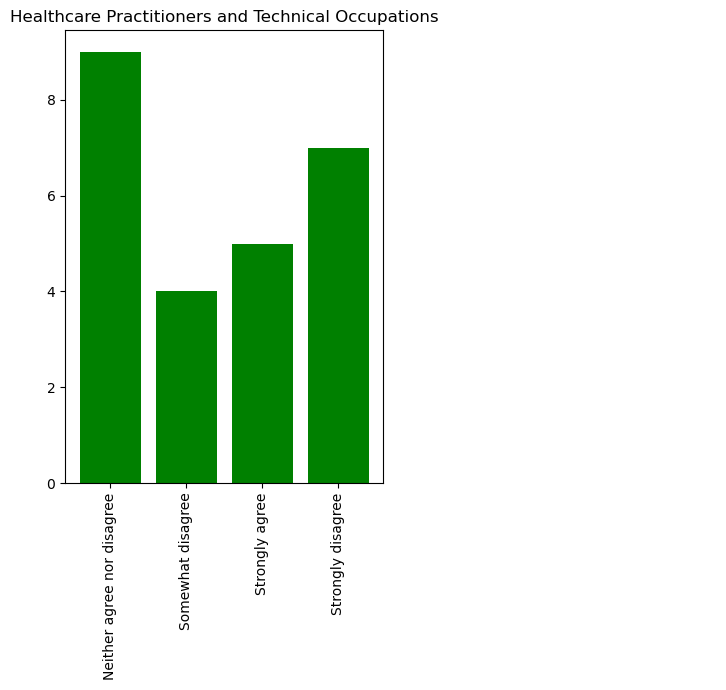

In [9]:
group_analysis('Which of the following best describes your current occupation?', eval_topic, main_dataframe)

The occupation status, how people spent their energy and stay in exchange with others over the day, most of the times don't show a clear perference. Managers, Business & Financial Operations Occupations, and maybe also Architects & Engineers seem to rather disagree. What usually connects this group is their office activities.

### Influence of finances


Statistics: how all participants voted for this question in general


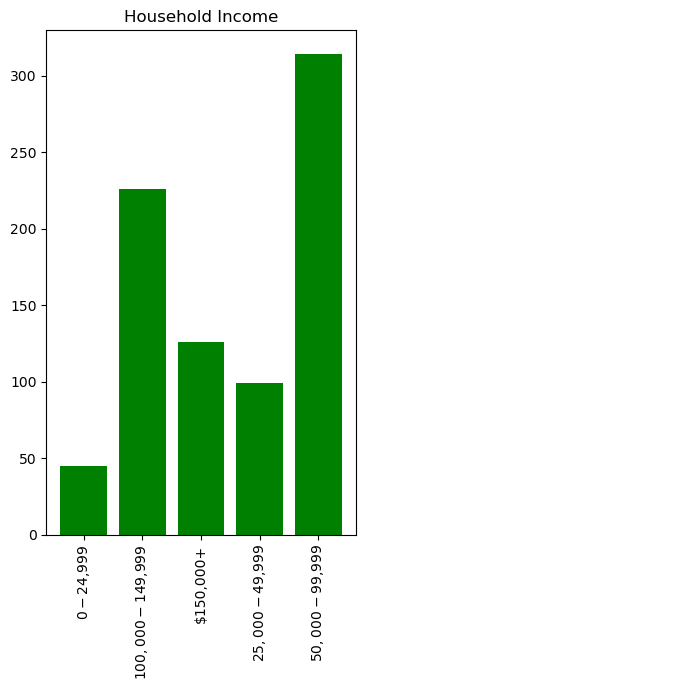


Topic: 'To what extent do you agree with the following statement: "sleeping in separate beds helps us to stay together."'



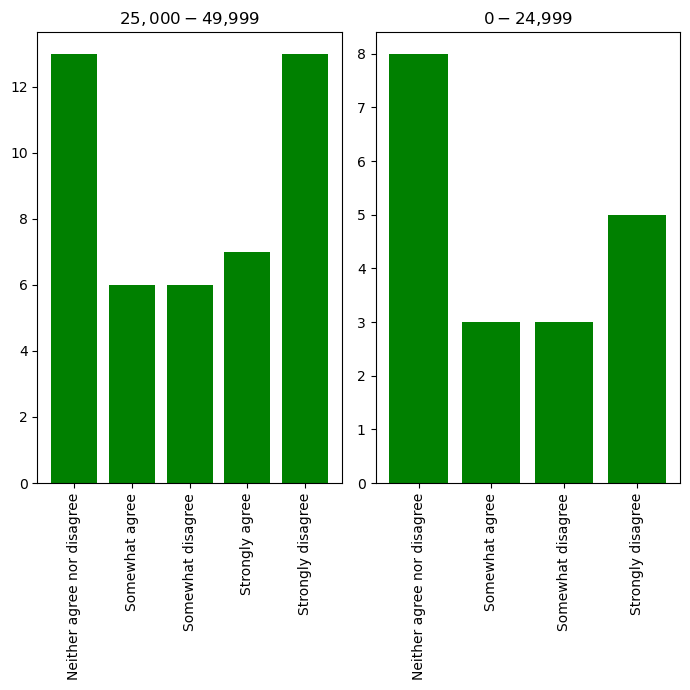

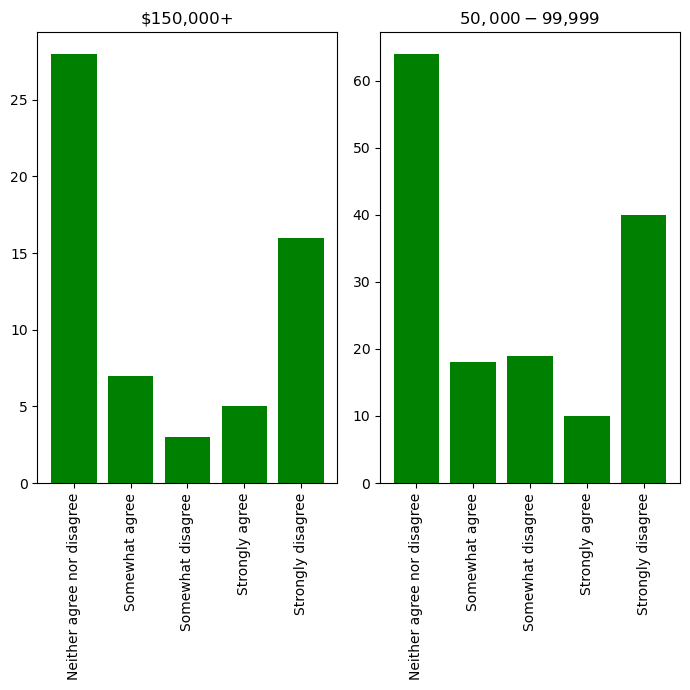

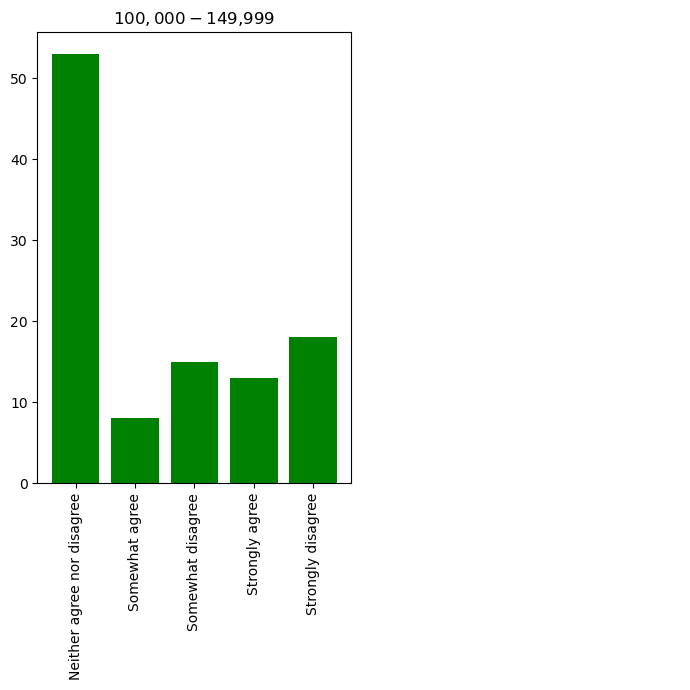

In [10]:
group_analysis('Household Income', eval_topic, main_dataframe)

The financial stiuation doesn't seem to take any influence at all, all sub groups look similar distributed.

### Influence of education


Statistics: how all participants voted for this question in general


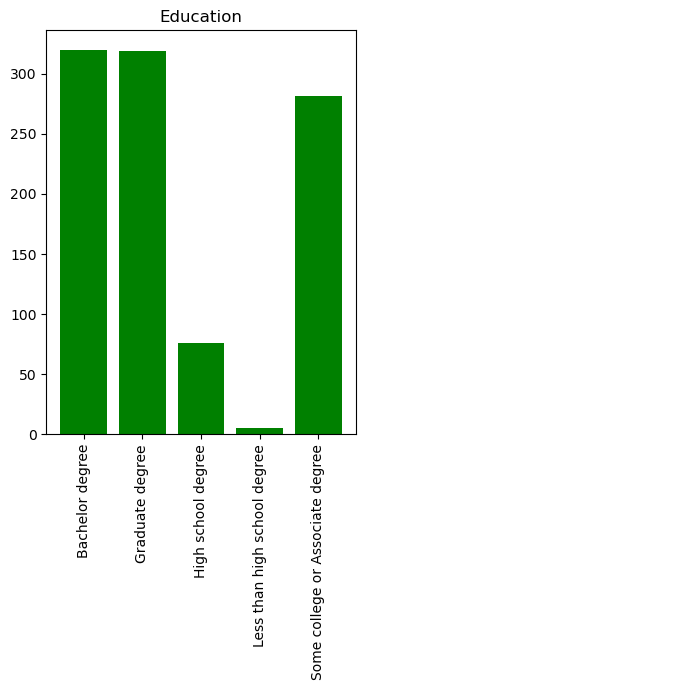


Topic: 'To what extent do you agree with the following statement: "sleeping in separate beds helps us to stay together."'



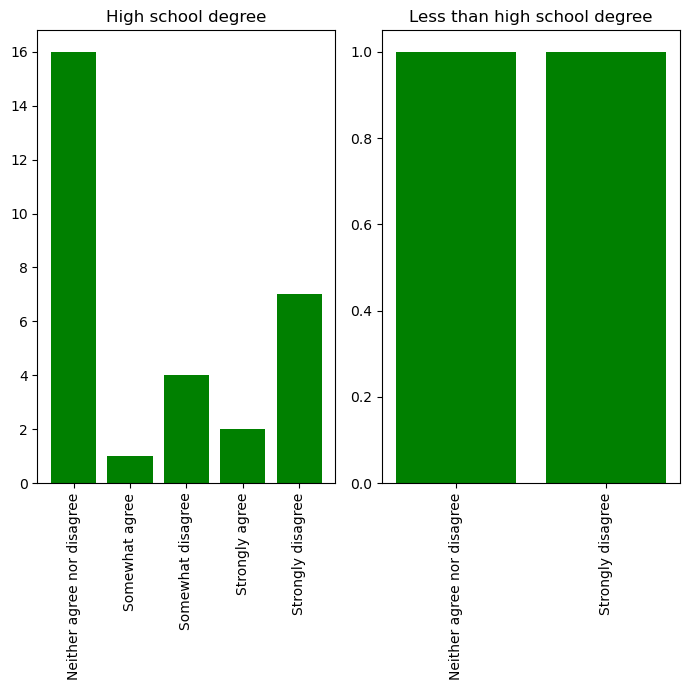

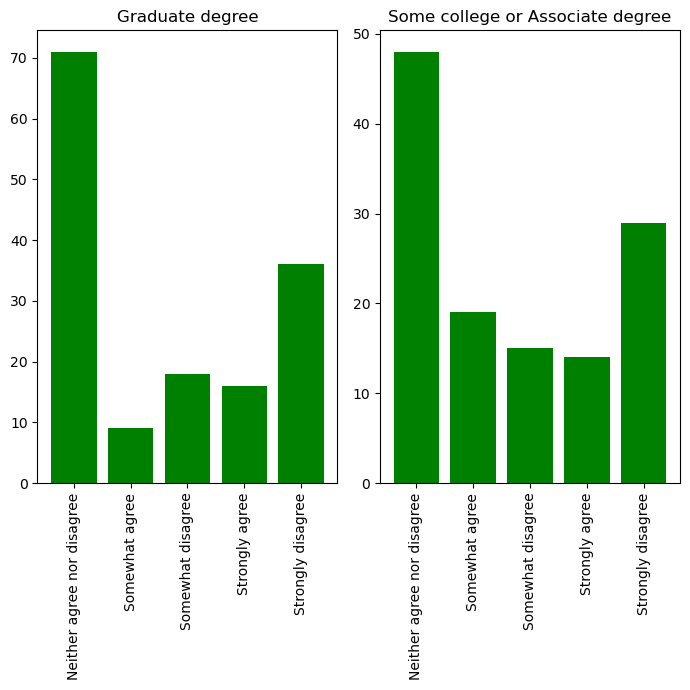

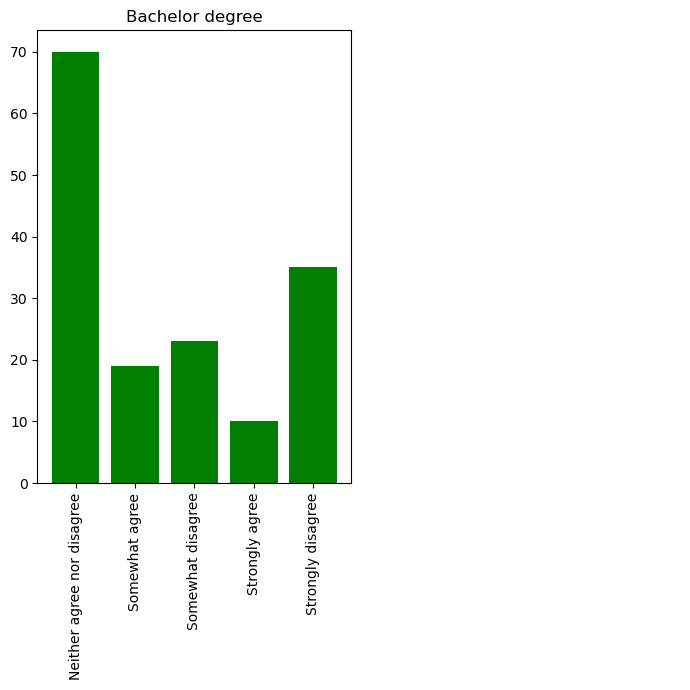

In [11]:
group_analysis('Education', eval_topic, main_dataframe)

Education level shows smaller nuances, but nothing worth focusing on so far.

### Influence by the individual's area


Statistics: how all participants voted for this question in general


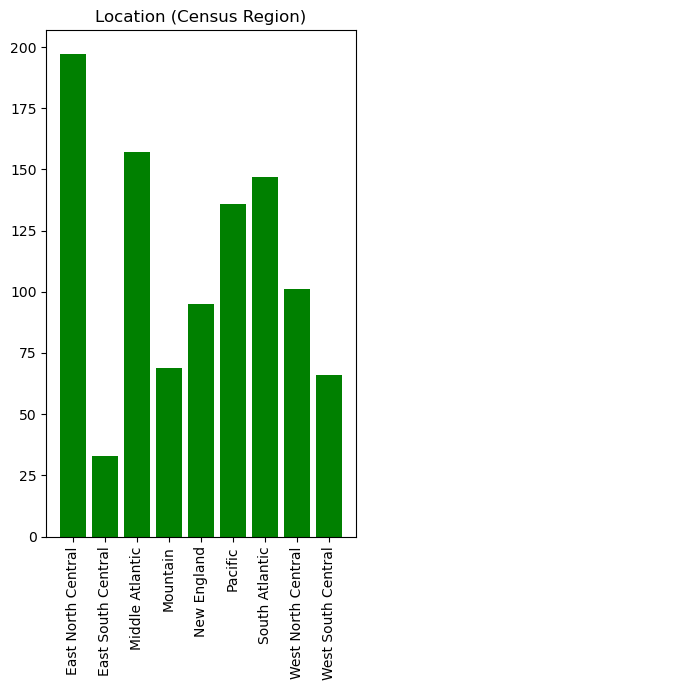


Topic: 'To what extent do you agree with the following statement: "sleeping in separate beds helps us to stay together."'



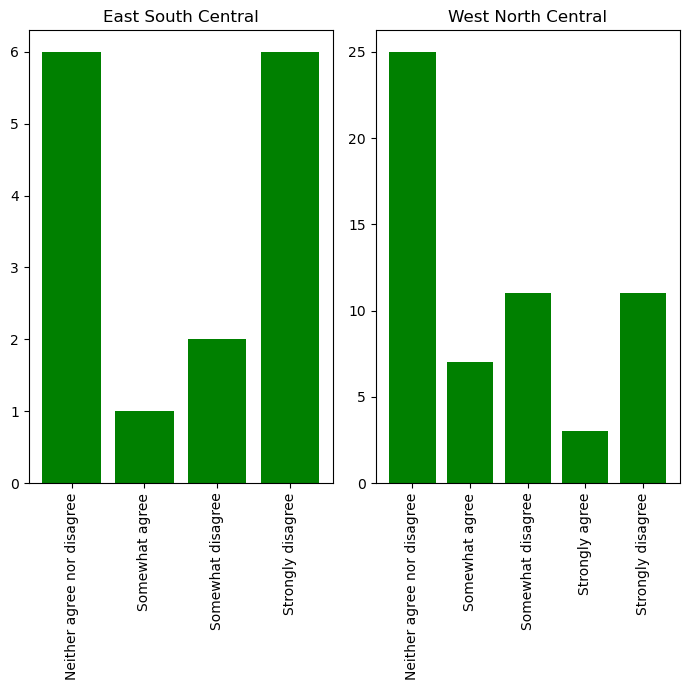

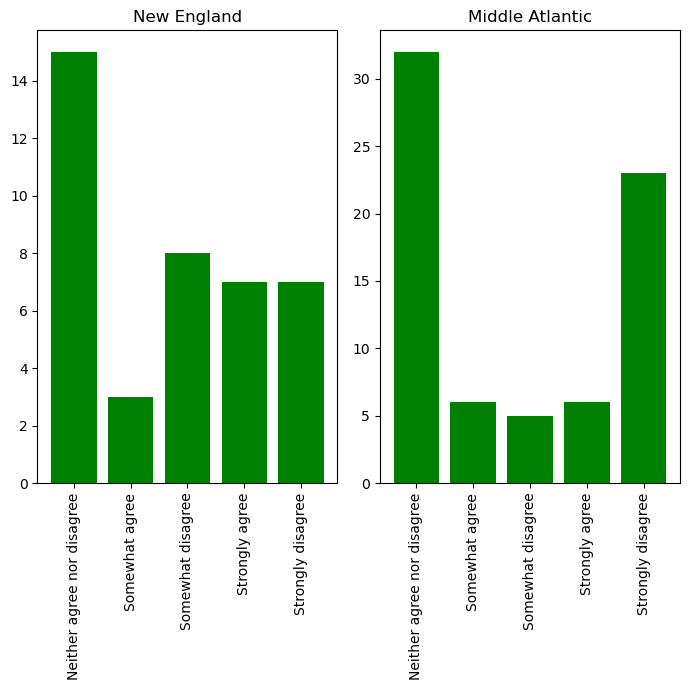

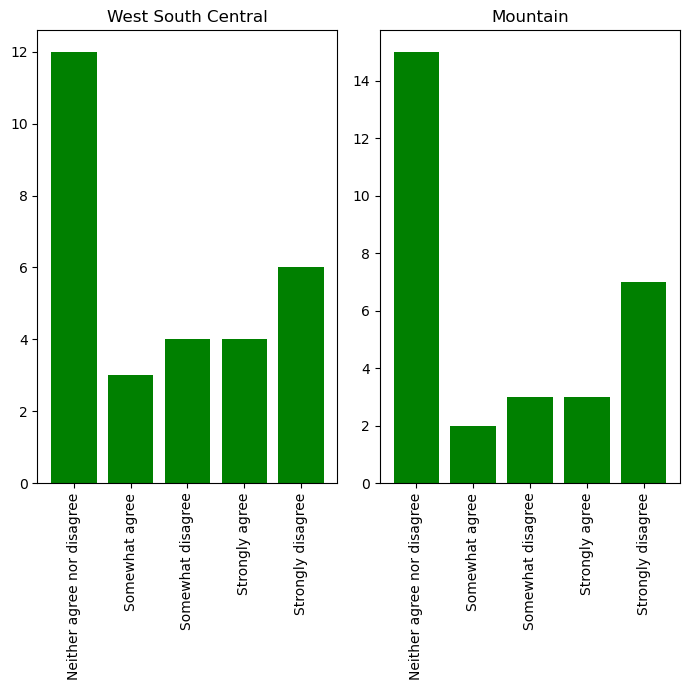

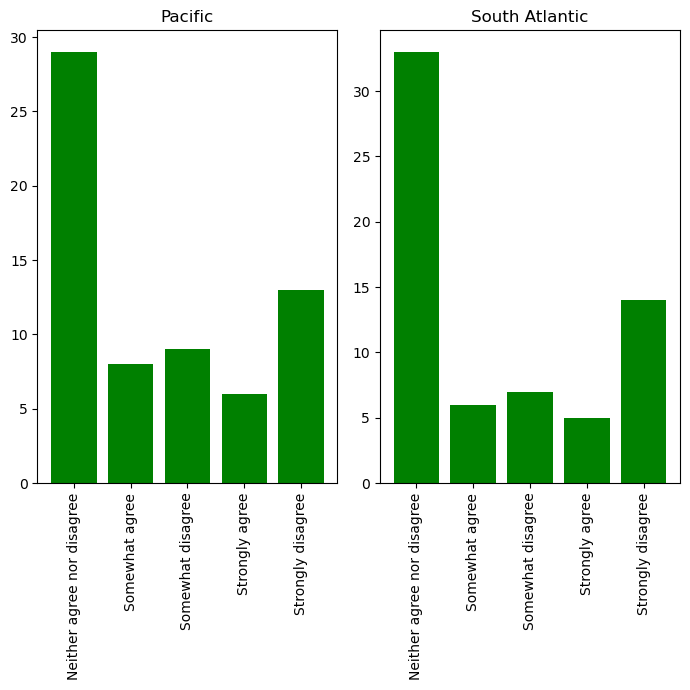

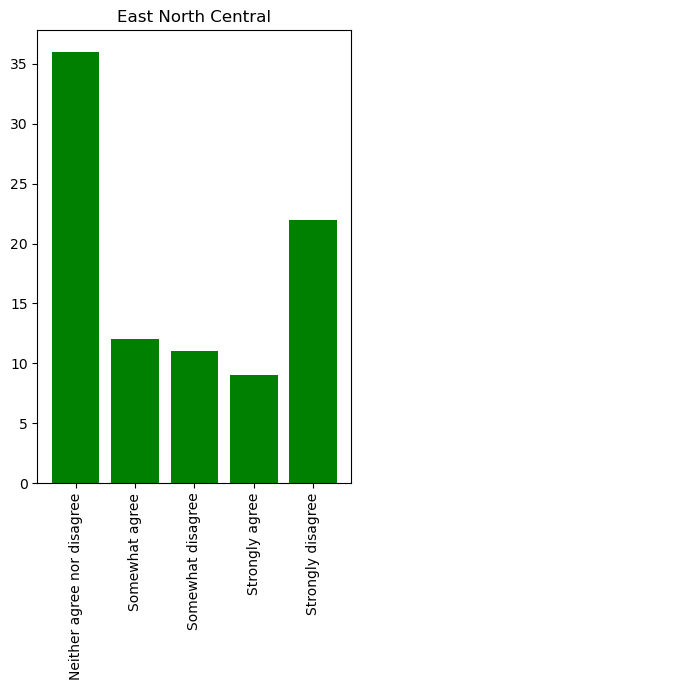

In [12]:
group_analysis('Location (Census Region)', eval_topic, main_dataframe)

Mid atlantic and Mountain areas rather disagree, whereas West North Central or new England hold back on that opinion.

## Influence by age


Statistics: how all participants voted for this question in general


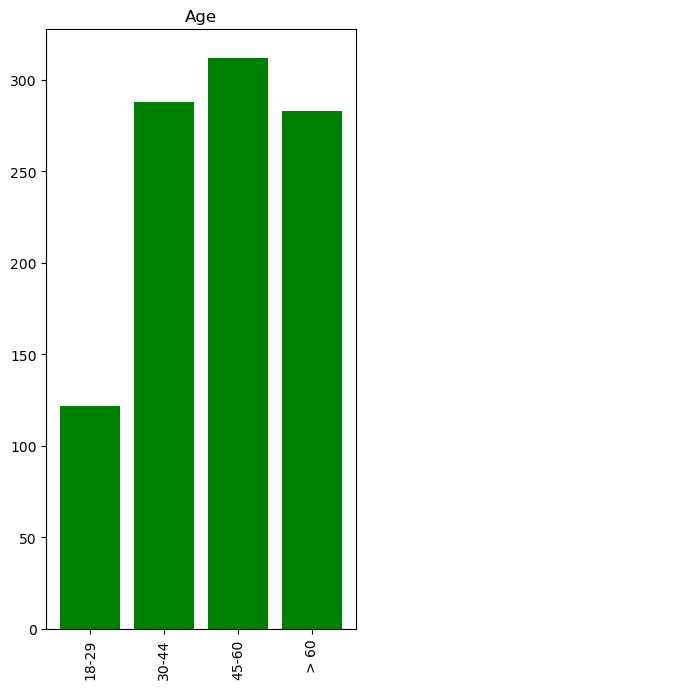


Topic: 'To what extent do you agree with the following statement: "sleeping in separate beds helps us to stay together."'



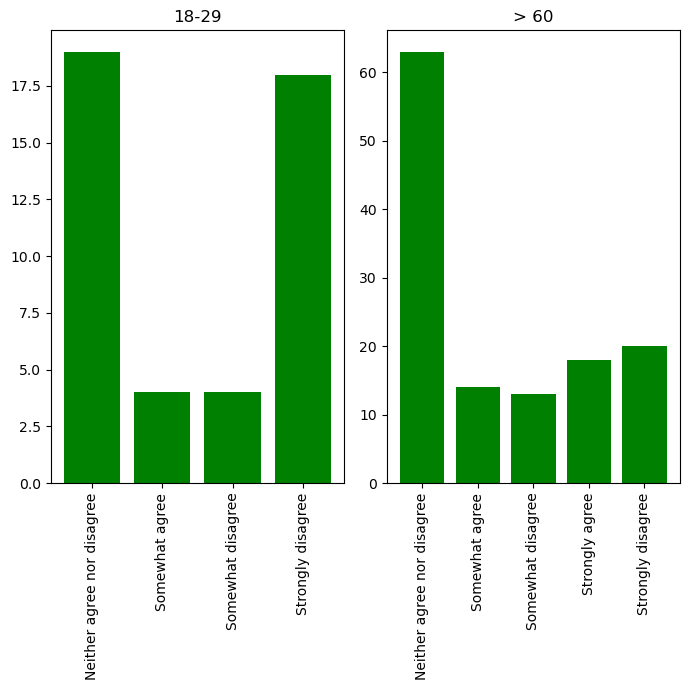

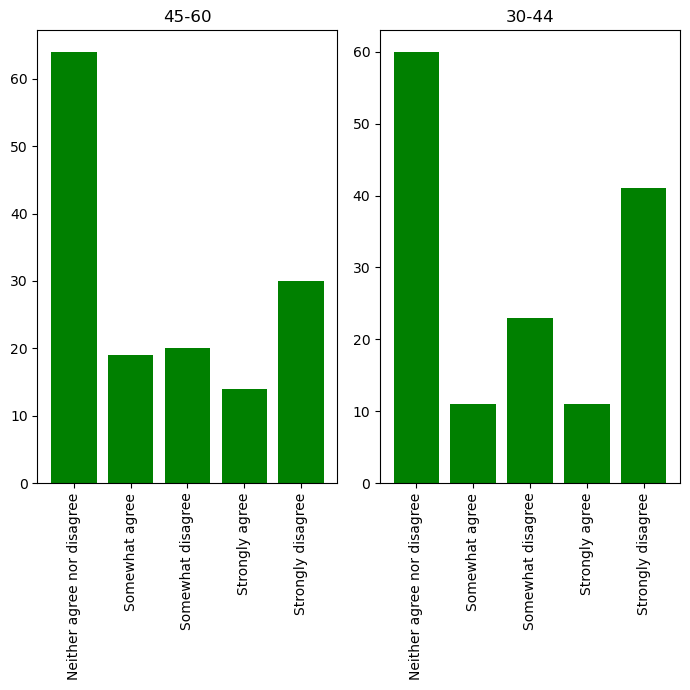

In [13]:
group_analysis('Age', eval_topic, main_dataframe)

Some interesting insights are shown by age, where it seems like the older one gets the more relaxed the answer is chosen. Particular for the young on average it appears to be important to share the same bed together.

### Influence by relationship duration


Statistics: how all participants voted for this question in general


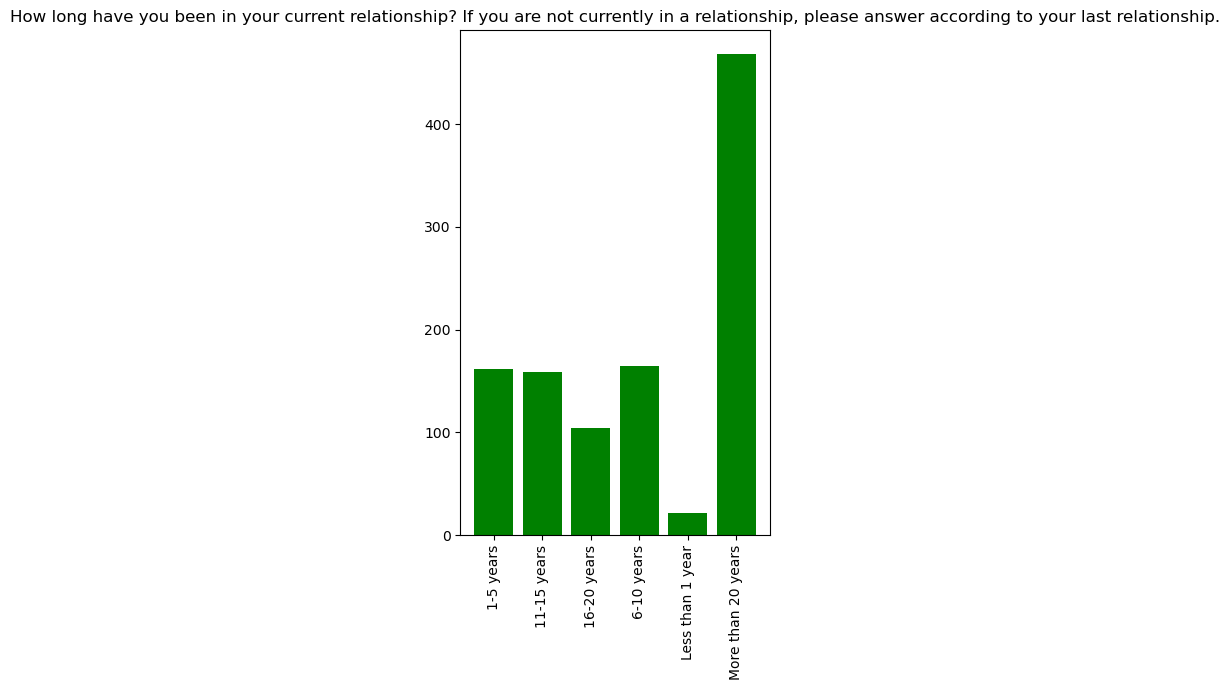


Topic: 'To what extent do you agree with the following statement: "sleeping in separate beds helps us to stay together."'



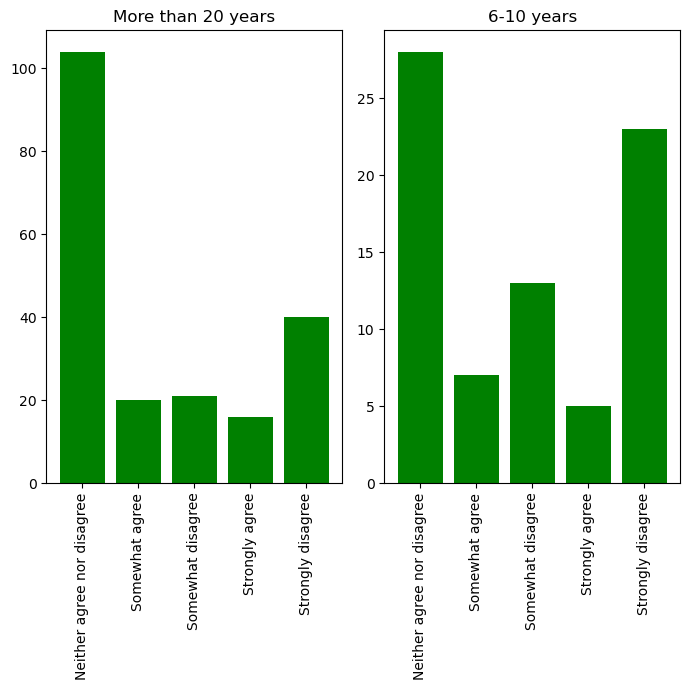

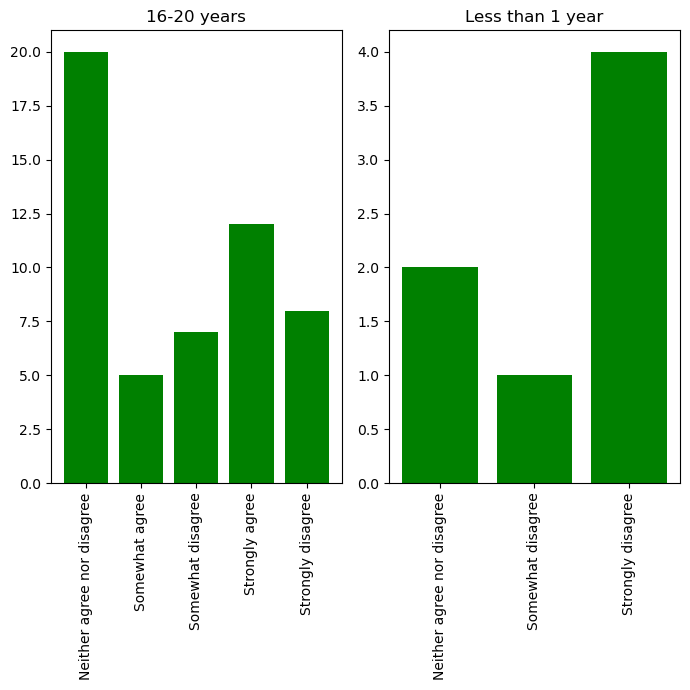

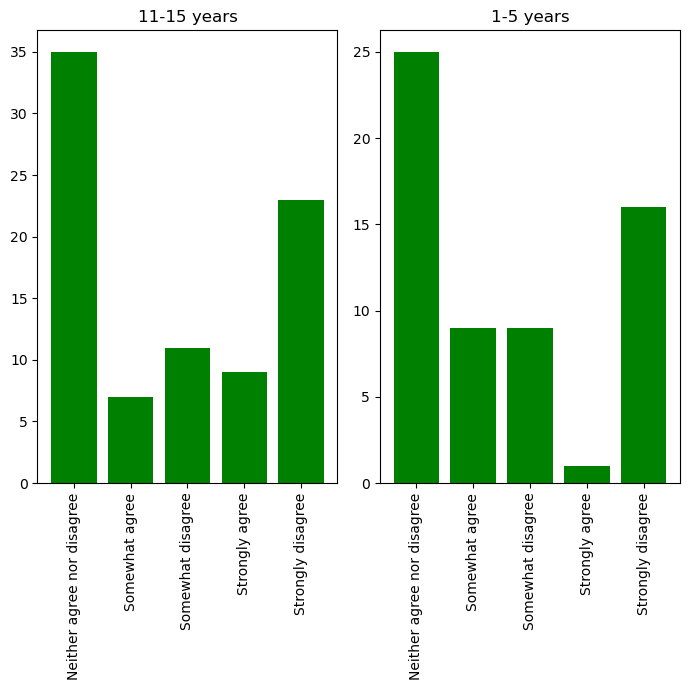

In [14]:
group_analysis('How long have you been in your current relationship? If you are not currently in a relationship, please answer according to your last relationship.', eval_topic, main_dataframe)

The duration of the relationship shows another interesting pattern. Long-time relation ship may rather agree to the evaluation topic, to separate the beds, though it must also be said that the distribution is similar to the other evaluations before.

## What seems significant for either group

This approach turns the perspective and rather separates the two groups by

In [15]:
together_df = main_dataframe.loc[(main_dataframe[eval_topic] == "Strongly disagree") | (main_dataframe[eval_topic] == "Somewhat disagree")]
separated_df = main_dataframe.loc[(main_dataframe[eval_topic] == "Strongly agree") | (main_dataframe[eval_topic] == "Somewhat agree")]

and investigates what the peers might have in common

In [16]:
def peer_group_evaluation(query, together_df, separated_df):
    """
    Put the feature evaluation in contrast to tendendcies of people that especially agree or disagree on the topic
    
    Paramters:
        query (str): question that should be evaluated
    """
    separate_ds = separated_df.get(query).value_counts()
    together_ds = together_df.get(query).value_counts()
    bar_plot([separate_ds.index, together_ds.index], 
             [separate_ds.values, together_ds.values], 
             ["tendency for separate beds", "tendency to sleep together"])


### First occurence of not sleeping together

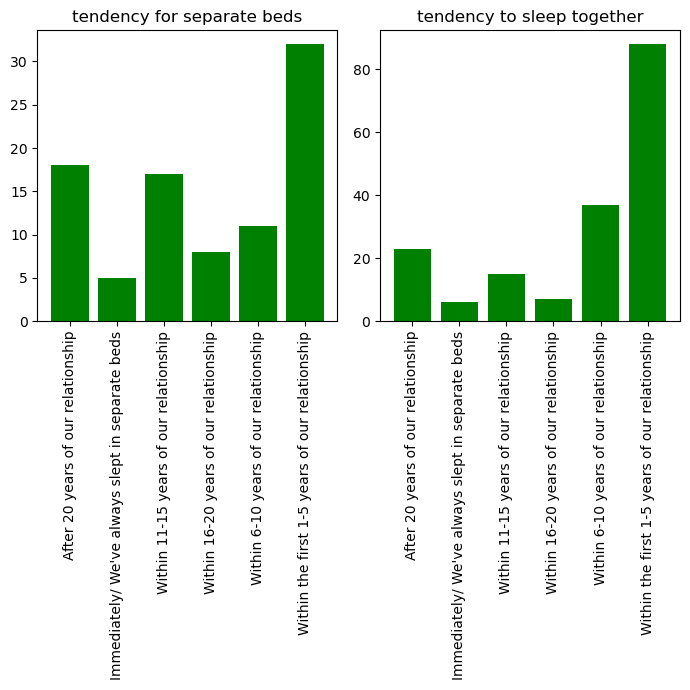

In [17]:
peer_group_evaluation("When was the first time you slept in separate beds?", together_df, separated_df)

This evaluation points out, that the couples, who from earliest beginning of their relation ship sleeped in different beds, have rather a strong opinion on that topic. 

### Frequency of sharing a bed

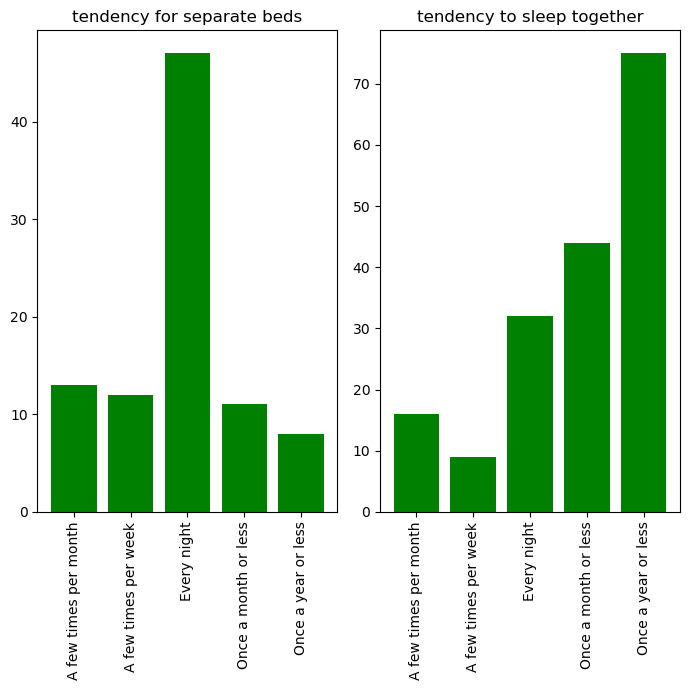

In [18]:
peer_group_evaluation("When both you and your partner are at home, how often do you sleep in separate beds?", together_df, separated_df)

Here we can see two canny characteristics. On the one hand the ones that like to sleep together, rather avoid occations of being apart. While on the other hand, the group that like to stay in separate beds perfer doing that every night and have no clear tendency otherwise.

### Household income

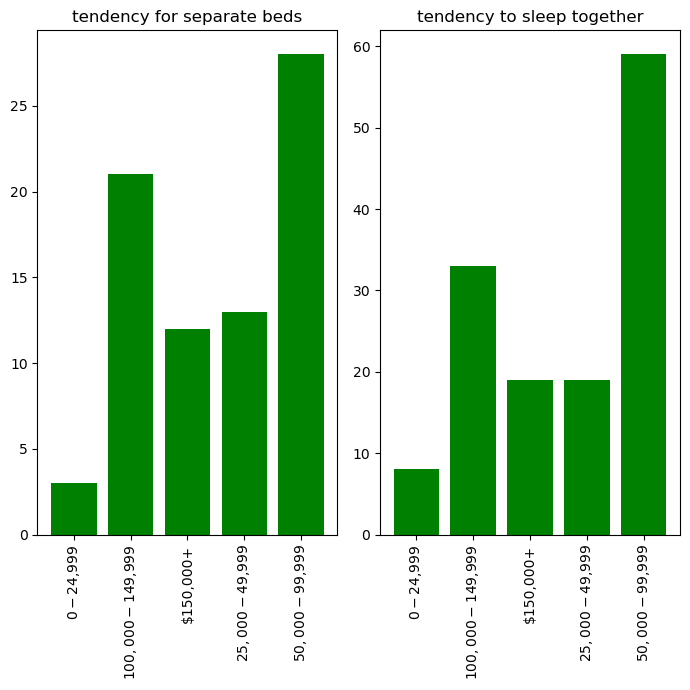

In [19]:
peer_group_evaluation("Household Income", together_df, separated_df)

Same recognition as above, practically no separation by this topic

## Combination of features

From this position, further operations like manually combining various features could be applied. But a similar information could also extracted by applying machine learning methods.

In this chapter classifiers will be trained, the performance and eventually their feature selection analysed.

This will be focused on following subset of features (questions like frequency of sleeping in separate beds is left out, because they seem like rather a consequence than a person's attribute) 

In [20]:
training_features = [
       'Which of the following best describes your current relationship status?',
       'How long have you been in your current relationship? If you are not currently in a relationship, please answer according to your last relationship.',
       'When was the first time you slept in separate beds?',
       'To what extent do you agree with the following statement: "we sleep better when we sleep in separate beds."',
       'To what extent do you agree with the following statement:ë_"our sex life has improved as a result of sleeping in separate beds."ë_',
       'Which of the following best describes your current occupation?',
       'Unnamed: 25', 'Gender', 'Age', 'Household Income', 'Education',
       'Location (Census Region)']

For this, decision trees single and ensemble methods are used, since they usually perform well on categorical data

In [21]:
clf = RandomForestClassifier(random_state=3, n_estimators=20)
training_set = main_dataframe.get(training_features)
X_main = pd.get_dummies(training_set)
y_sleeptogether = (main_dataframe[eval_topic] == "Strongly disagree") | (main_dataframe[eval_topic] == "Somewhat disagree")
class_names = ["separate", "together"]

X_train, X_test, y_train, y_test = train_test_split(X_main, y_sleeptogether, test_size=0.33, random_state=3)
clf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=20, random_state=3)

After the classifier has been trained, the feature importance can be checked with an impurity graph

In [22]:
def visualize_feature_impurity(clf, features, focus_min_performance=0.02): 
    """
        Visualizes feature importance by impurity of a trained classifier.
        
        Paramters:
            clf: the classifier to be evaluated
            features: the name of features that have been used for training, used for graph labels
            min_performance: streamline output to the most promising ones, avoid display difficulties. 
    """
    # extract characteristics
    std_dev = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
    forest_importances = pd.Series(clf.feature_importances_, index=features)#[feature for feature in features])
    
    # focus on best peforming features
    focus_group = forest_importances > focus_min_performance
    focused_forest_importances = forest_importances[focus_group]
    focused_std_dev = std_dev[focus_group]

    # plot it
    fig, ax = plt.subplots()
    focused_forest_importances.plot.bar(yerr=focused_std_dev, ax=ax)
    ax.set_title("Feature importances")
    ax.set_ylabel("Mean decrease in impurity")

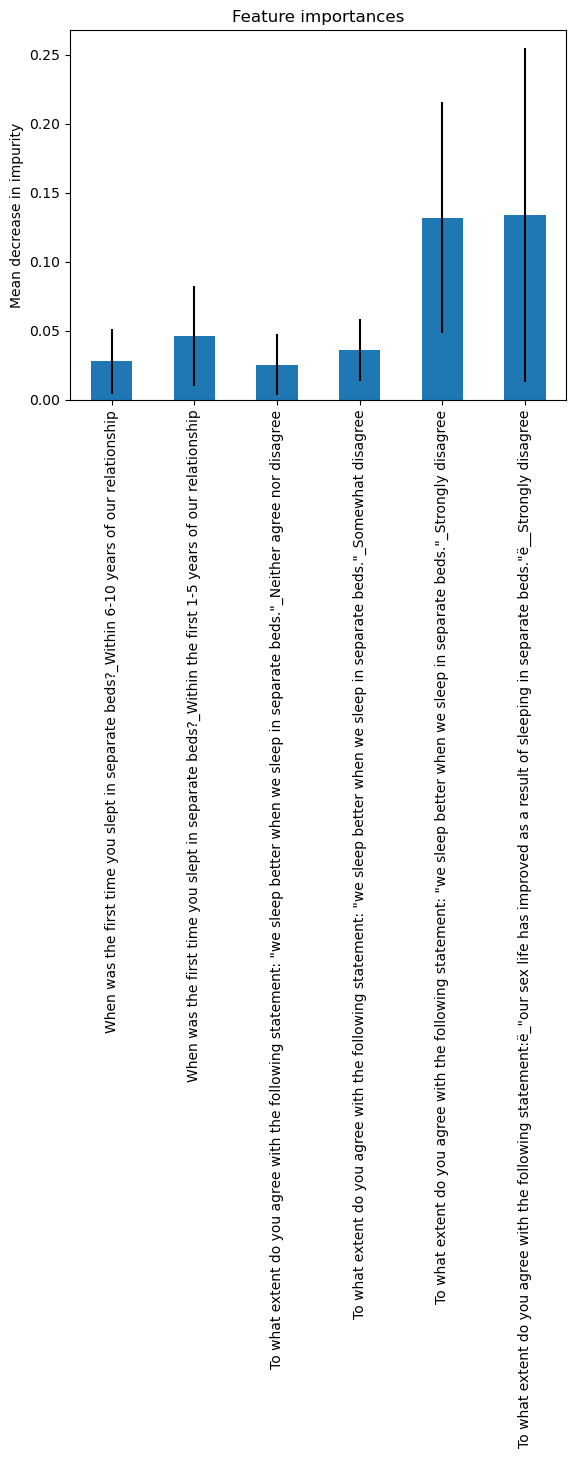

In [23]:
visualize_feature_impurity(clf, X_train.columns)

That gives a first impression on how the eval topic could be answered. First the performance needs to be evaluated, indicating how much these results could be trusted.

In [24]:
y_predict = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_predict)
print("accuracy " , accuracy)

accuracy  0.8867403314917127


Good enough to get an impression.

A representation in what combination these features could be used, would also be helpful. For this a single decision tree is trained and it's structure evaluated.

In [25]:
def visualize_decision_tree_path(feature_namings, class_names, accuracy_tolerance=0.9, debug_print=False):
    """
        Extract and show the trained decision tree structure
        
        Parameters:
            feature_namings: name of the features the classifier has been trained with.
            accuracy_tolerance: onto which tolerance it will be exceptable to stop looking for an appropriate approximation.
            class_names: label that will be attached to class category in tree structure
            debug_print: print textual output of the decision tree structure.
    """
    cur_max_depth = 1
    accuracy = 0.0
    
    # look for tree with smallest depth to be able to display it in jupyter and for an easier story telling
    while accuracy <= accuracy_tolerance:
        clf = tree.DecisionTreeClassifier(max_depth = cur_max_depth)
        clf.fit(X_train,y_train)
        predict = clf.predict(X_test)
        cur_max_depth += 1
        accuracy = accuracy_score(y_test, predict)

    # prepare plot titles 
    querries = [desc.split("_")[0] for desc in feature_namings]
    querries = [f"{feature}\n{desc.split('_')[1]}" for feature, desc in zip(querries, feature_namings)]

    fig = plt.figure(figsize=(45,25))
    dbg = tree.plot_tree(clf, fontsize=15, 
                       feature_names=querries,
                       class_names=class_names,
                       filled=False)
    if debug_print:
        print(dbg)

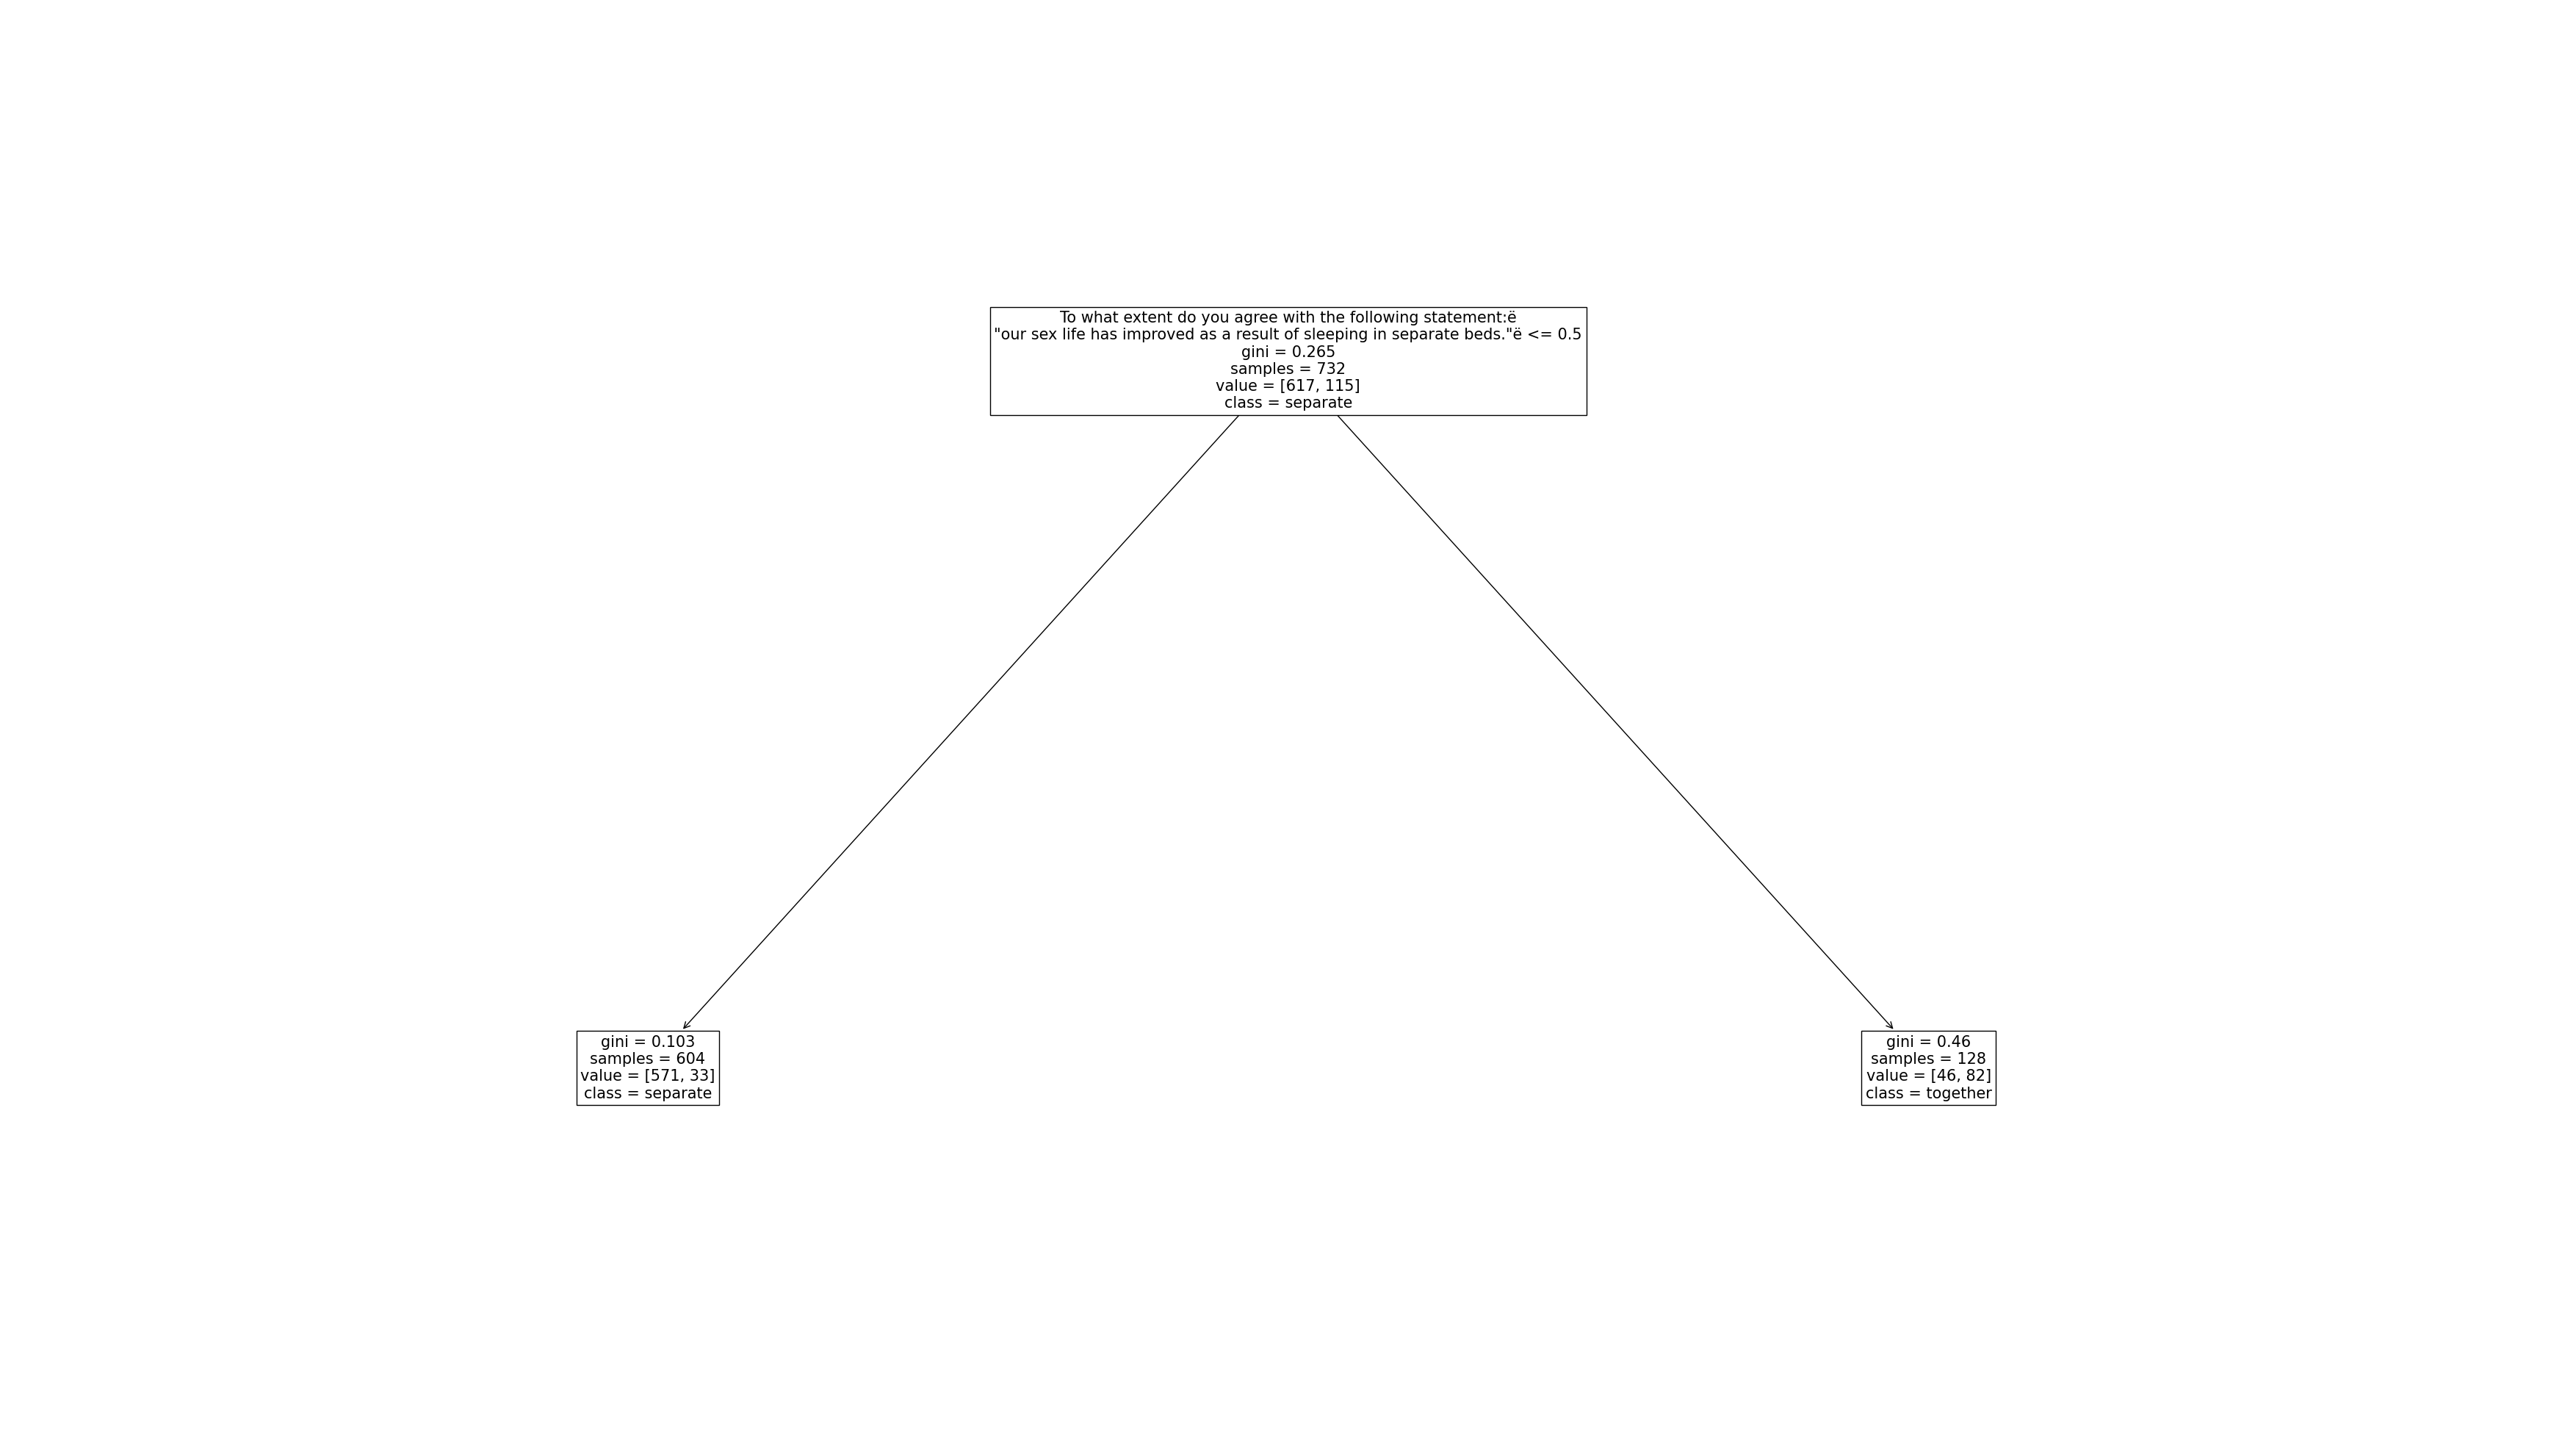

In [26]:
visualize_decision_tree_path(X_train.columns, class_names, accuracy/1.01)

This separation strategy is not flawless according to accuracy, but it managed to separate the group by one feature.

Comparing the oposite's group's signature is interesting too.

In [27]:
y_separate = (main_dataframe[eval_topic] == "Strongly agree") | (main_dataframe[eval_topic] == "Somewhat agree")
class_names = ["together", "separate"]
X_train, X_test, y_train, y_test = train_test_split(X_main, y_separate, test_size=0.33, random_state=3)
clf = RandomForestClassifier(random_state=3)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=3)

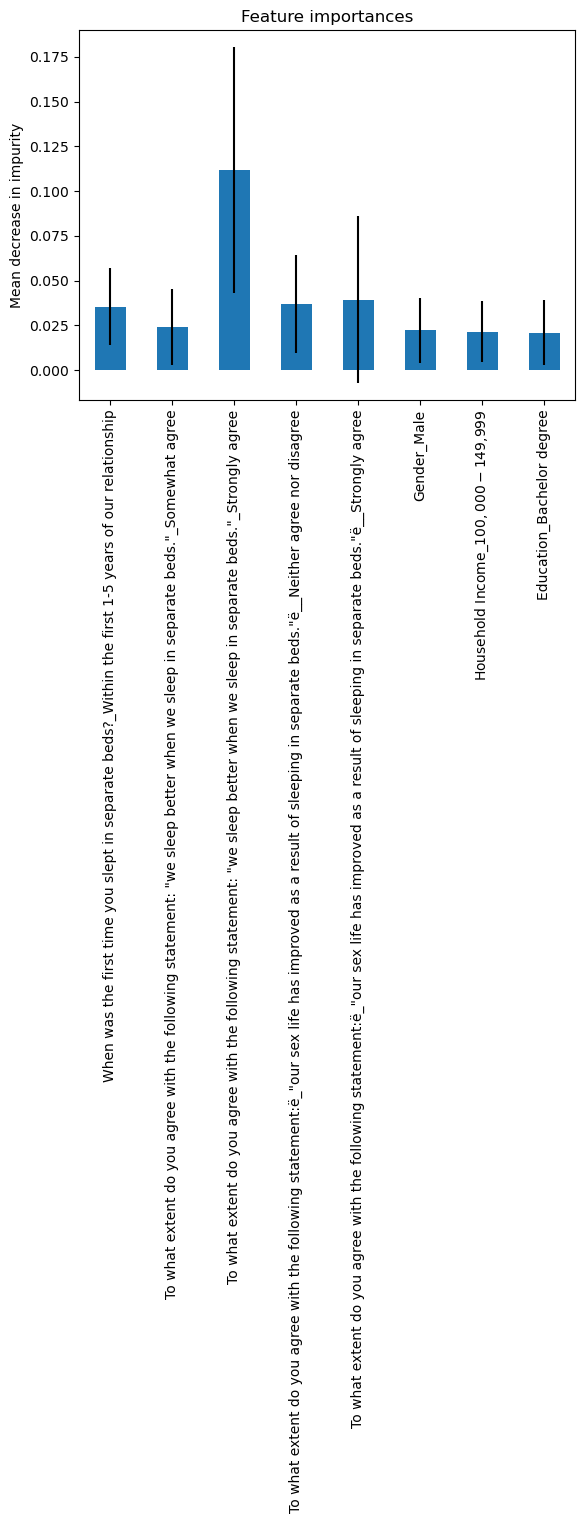

In [28]:
visualize_feature_impurity(clf, X_train.columns)

Not too much of a surprise, but here many other features are necessary.

0.9060773480662984


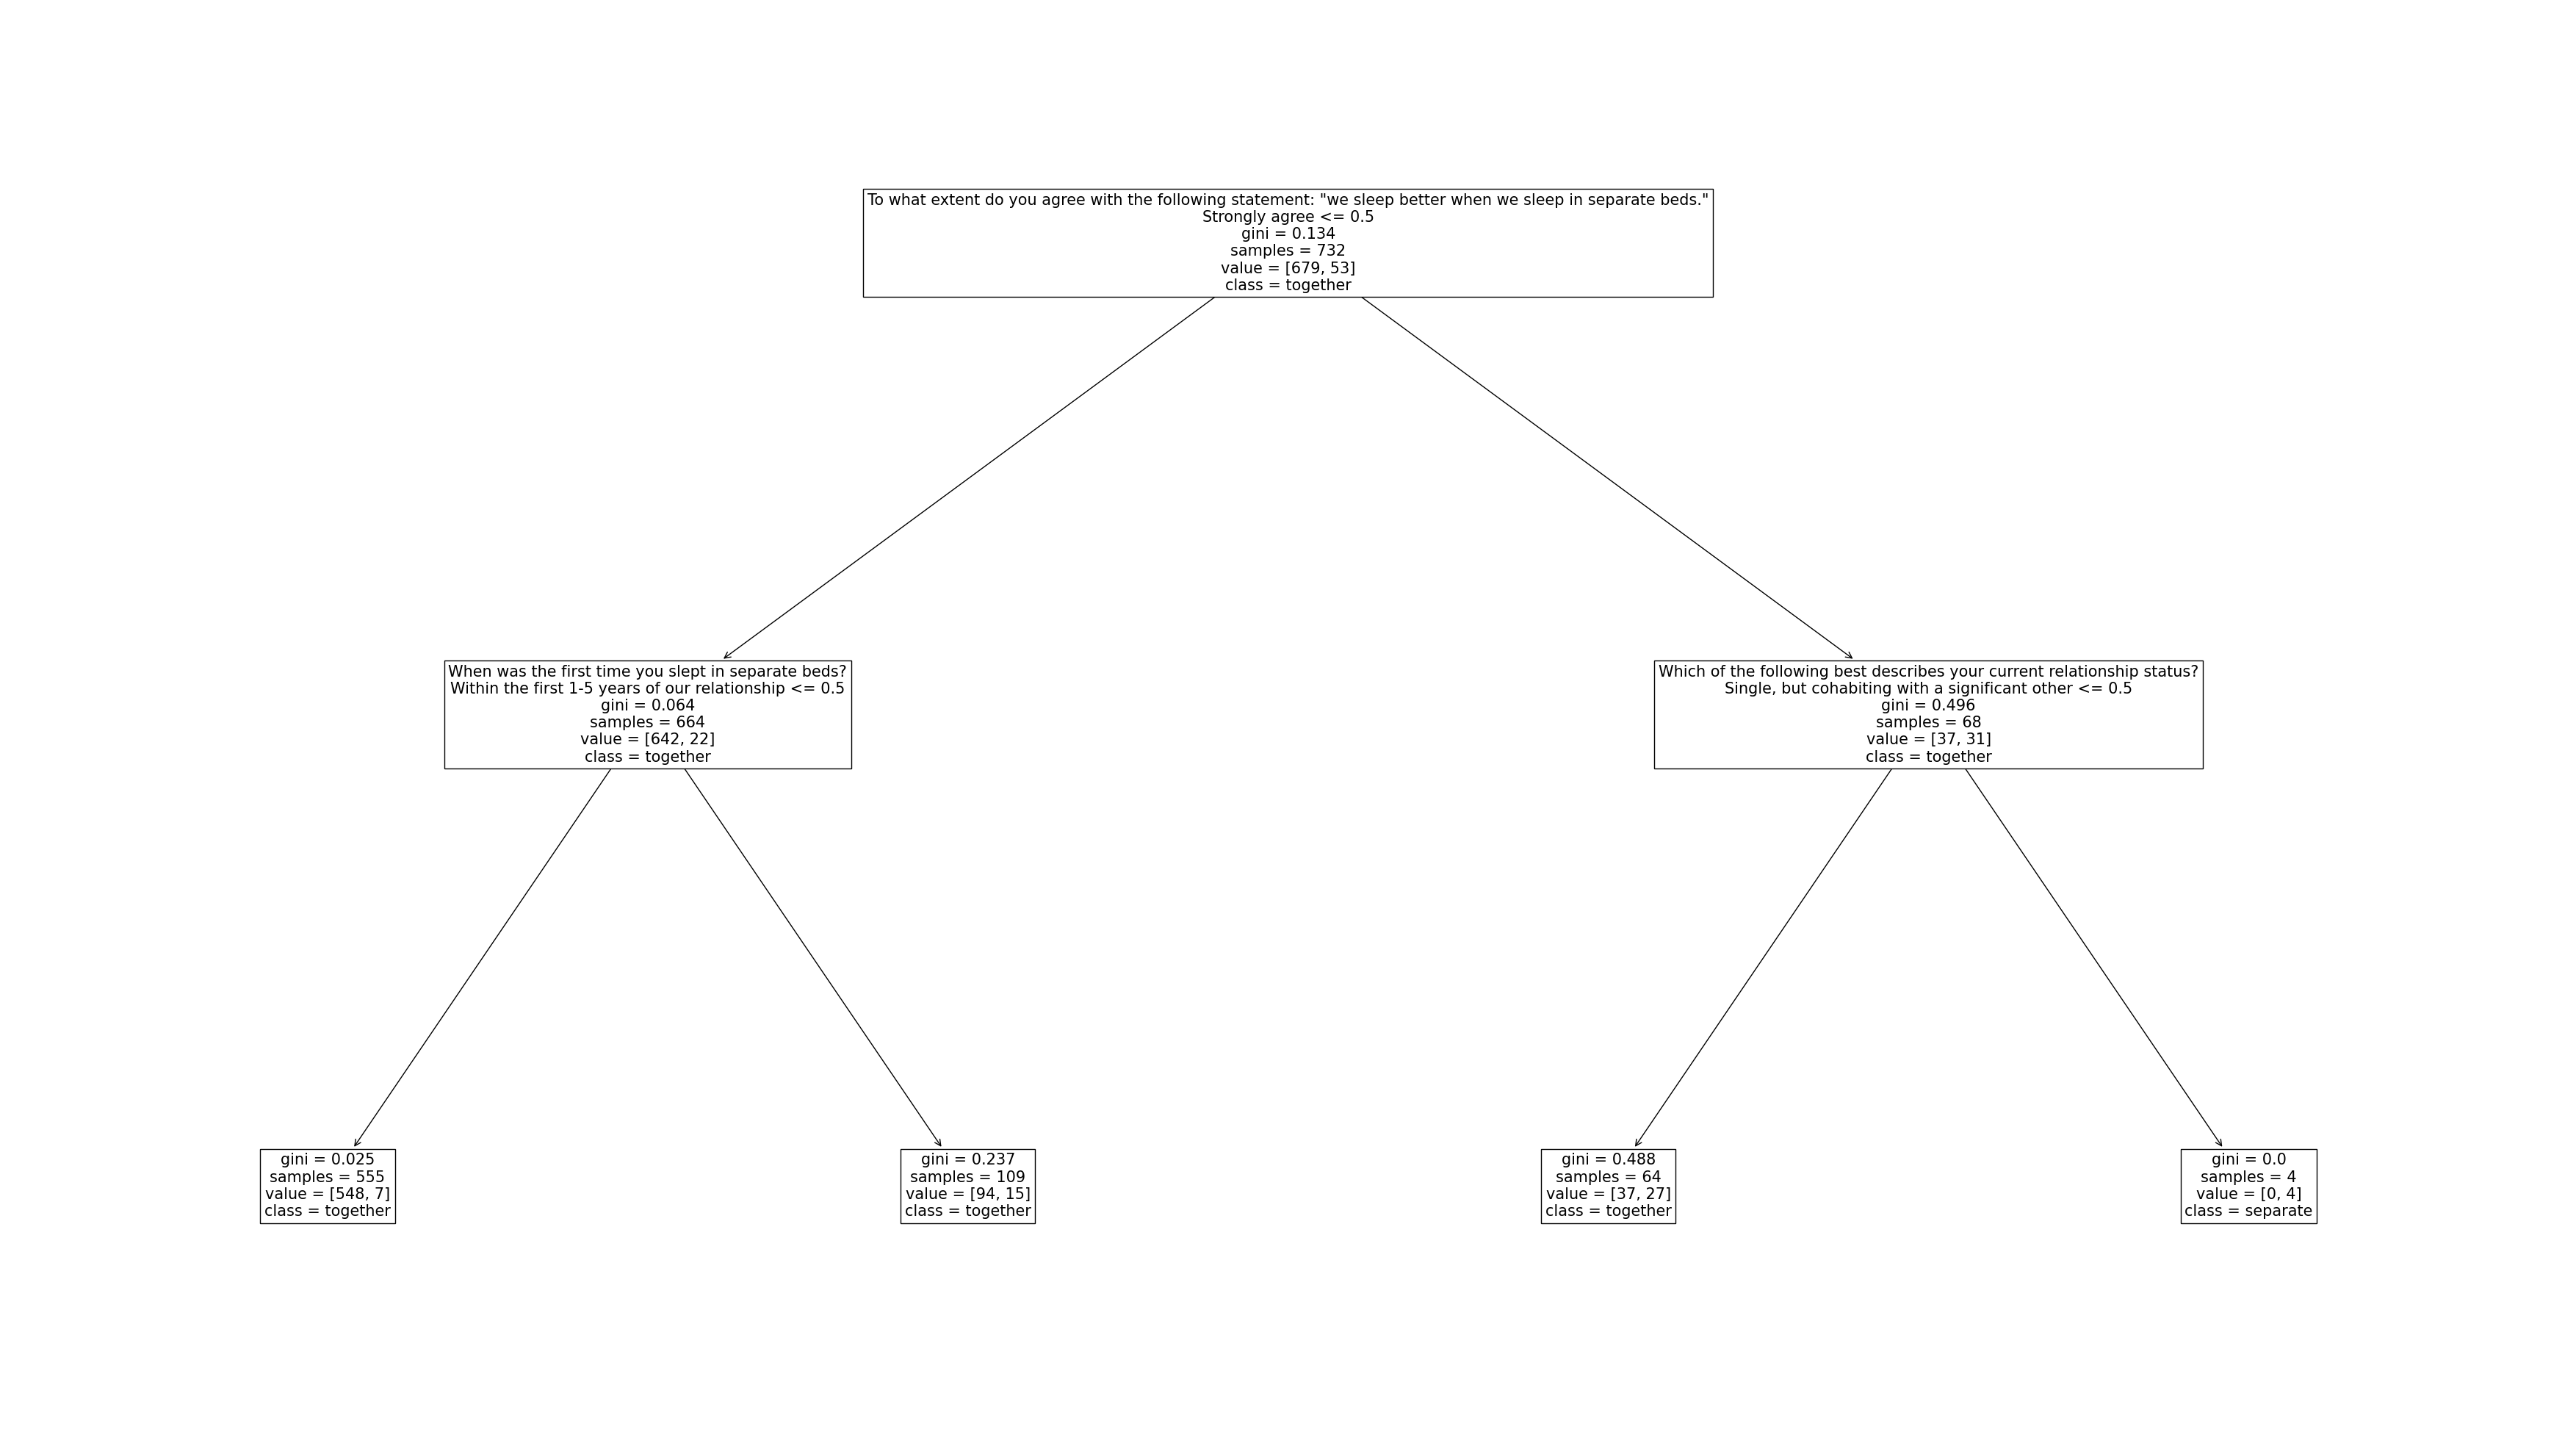

In [29]:
y_predict = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_predict)
print("accuracy: ", accuracy)
visualize_decision_tree_path(X_train.columns, class_names, accuracy/1.01)

So let's verify the analysis with exposing the most important feature in a graph

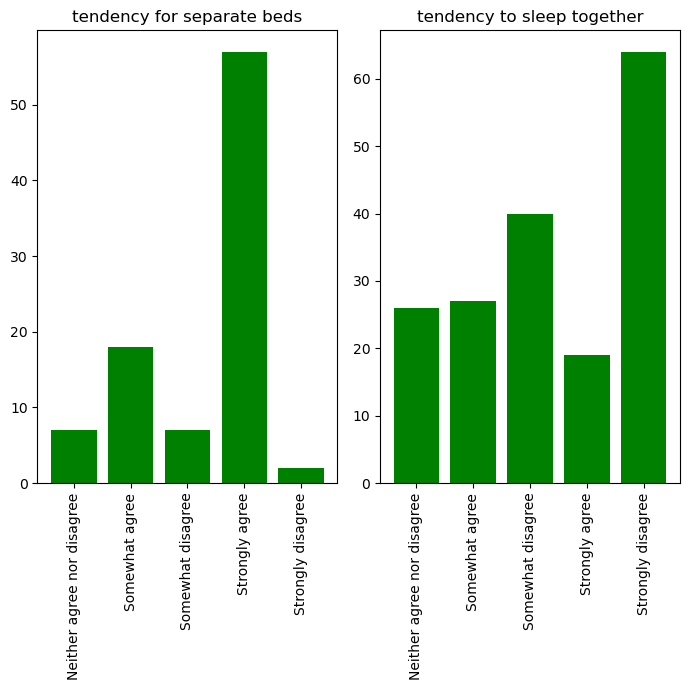

In [30]:
peer_group_evaluation('To what extent do you agree with the following statement: "we sleep better when we sleep in separate beds."', together_df, separated_df)

Taking a glance on the most significant feature, we’ll see that the opinion on *we sleep better when we sleep in separate beds* appears to be significant for both groups, but especially for the focused group is even a stronger feature

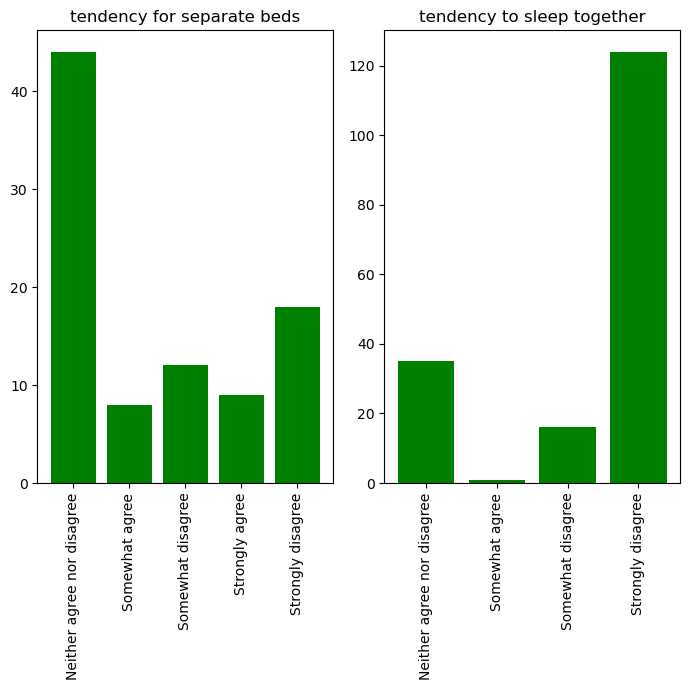

In [31]:
peer_group_evaluation('To what extent do you agree with the following statement:ë_"our sex life has improved as a result of sleeping in separate beds."ë_', together_df, separated_df)

And there we can see it clearly separates the group, while it almost has no significance for the opposite group. So it comes clear it doesn’t show up in the other trained tree structure.

## Conclusion

The authors placed interesting questions in the survey to elaborate sleeping behaviours. Low level feature analysis may reveal partially weak tendencies for a certain behaviour, but it also stood out that a single feature alone won't give away an individual's most likely tendency. 

Key takeaway messages:
- If the coitus of a couple does not improve, it is more likely to sleep together.
- Sleeping in separate beds is a bit more complicated but can be explained, one of the bigger influence factor is sleeping quality.
- Office job takers appear to have a tendency towards sleeping together.
- After all in the dataset certain groups appear to be under- or overrepresented.